# Import packages

In [1]:
import json
import glob
import os
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [20,20]

# Define Functions to read data

In [2]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path):
    dir_name = full_path
    results = []
    it = 0
    try:
        while True:
            with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
                data = json.load(json_file)
                if it % 1 == 0:
                    print(it)
                results.append(data)
            it += 1
    except:
        print("Finished reading ", full_path)
    return results

#extract number from file
def extract_number(f):
    s = re.findall("\d+$",f)
    return (int(s[0]) if s else -1,f)

'''Human sorting of files '''
'''From https://nedbatchelder.com/blog/200712/human_sorting.html '''
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)

def read_experiment_results_agnostic(full_path):
    results = []
    filenames = glob.glob(pathname = 'iteration_?*', root_dir = full_path)
    filenames_ordered = human_sort(filenames)
    try:
        for file in filenames:            
            json_file = open(Path(os.path.join(full_path, file)))
            data = json.load(json_file)
            if extract_number(file)[0] % 1 == 0:
                print(file)
            results.append(data)
    except:
        print("Error in reading results ", full_path)
    return results




# Specify where to get results from and load (system agnostic version).

It is necessary to:
1. set the folder in `result_folde_path_from_root` as a list of all the folders starting from the root down to the one containing the runs (assumes root is the parent dir of the dir containing this script)
2. set the runs numbers to analyze as a range `run_number` between 1 and N where n is the number of runs

### Definition

In [3]:
#assuming folder with data for different tasks is in root directory
def load_results(folder, task, run_number):
  result_folder_path_from_root = os.path.join(folder, task)
  results_agnostic = []
  path = os.path.join(os.path.dirname(os.path.abspath(os.curdir)), result_folder_path_from_root) 
  print(path)

  for i in run_number: 
    file_path = os.path.join(path, "run_" + str(i))
    results_agnostic.append(read_experiment_results_agnostic(file_path))
  results_agnostic.append({'task': task})
  return results_agnostic

### Call

In [ ]:


run_number = range(1,12)
task = "cif_from_fmni"
folder = "many_runs"

results_agnostic = load_results(folder=folder, task=task,run_number=run_number)


# Defintion of functions to plot data


## Genealogy

In [5]:
from smart_phenotype import smart_phenotype, readable_phenotype
import random
def genealogy_string(results):
    import graphviz
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))
def load_archive(path, run_number, generation):
    with open(path + str(run_number) + '\\z-archive_' + str(generation) + ".json", 'r') as f:
        archive = json.load(f)
    return archive

## Heatmap and phenotypes

In [4]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def trim_phenotype(phenotype):
    if "shape" in phenotype:
        phenotype = phenotype.replace(", shape=shape, dtype=tf.float32", "")
        phenotype = phenotype.replace("tf.math.", "")
        phenotype = phenotype.replace("tf.", "")
        functions = phenotype.split(r'lambda shape,  alpha')

    elif "size" in phenotype:
        phenotype = phenotype.replace(", size=size, dtype=torch.float32", "")
        phenotype = phenotype.replace("torch.", "")        
        functions = phenotype.split(r'lambda size, alpha')
    
    else:
        raise Exception()

    return functions 

def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    return grad_func_string

## Defines class node

In [ ]:
class Node:
    def __init__(self, symbol, parent, child_count):
        self.symbol = symbol
        self.left = None
        self.right = None
        self.child = None
        self.parent = parent
        self.child_count = child_count
            
    def insert(self, child):
        if self.child_count == 2:
            if self.left is None:
                self.left = child
            elif self.left.is_full() == False:
                #print(f"inserting in {self.left.symbol}")
                self.left.insert(child)
            elif self.right is None:
                self.right = child
            elif self.right.is_full() == False:
                #print(f"inserting in {self.right.symbol}")
                self.right.insert(child)
            else:
                raise Exception(f"All two children are full:{self.symbol}({self.left.symbol}, {self.right.symbol}) [{self.get_root().to_string()}]")
        elif self.child_count == 1:
            if self.child is None:
                self.child = child
            elif self.child.is_full() == False:
                #print(f"inserting in {self.child.symbol}")
                self.child.insert(child)
            else:
                raise Exception(f"Child is full: {self.symbol}({self.child.symbol}) [{self.get_root().to_string()}]")
        else:
            raise Exception(f"Insert called on terminal: {self.symbol} [{self.get_root().to_string()}]")
            
    def is_full(self):
        #print(f"Calling is full on {self.symbol}")
        full = 0
        if self.child_count == 2:
            if self.left is None:
                full = False
            elif self.right is None:
                full = False
            elif self.left.is_full() and self.right.is_full():
                full = True
            else: 
                full = False
        elif self.child_count == 1:
            if self.child is None:
                full = False
            elif self.child.is_full():
                full = True
            else:
                full = False
        elif self.child_count == 0:
            full = True
        else:
            raise Exception(f"Symbol {self.symbol} does not 0, 1 or 2 children")
        return full
        
    def get_next(self):
        return self



    def to_string(self):
        string = ""
        if self.child_count == 2:
            string +="(" 
            if self.left is None:
                string += "_"
            else:
                string += self.left.to_string()
            string += self.symbol
            if self.right is None:
                string += "_"
            else:
                string += self.right.to_string()
            string += ")"
            
        elif self.child_count == 1:
            string += self.symbol + "(" 
            if self.child is None:
                string += "_"
            else:
                string += self.child.to_string()
            string += ")"
        else:
            string += self.symbol
        return string

    def get_root(self):
        if self.parent is not None:
            return self.parent.get_root()
        else:
            return self

# Aggregate all the data, it might take a few minutes to run

## Definition

In [6]:
def process_results(results, negative_fit=True, run_number=None):
    # print(epochs)
    best_individuals = {}
    averages_all = []
    averages = []
    bests_all = []
    bests = []
    stds_all = []
    best_of_all = []
    stds_best_all = []
    indivs = []
    indiv_fits = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 0
    run_best = np.zeros(len(results))

    # make sure last elemt corresponds to the task on which the individuals evolved
    # store the task to name the processed_results later
    # and take it out from data
    task = results[-1]
    assert type(task) == dict
    assert len(task) == 1
    assert "task" in task
    results = results[:-1]
    assert type(results[-1]) != dict

    # see the max n of gens in results
    generations = np.arange(len(max(results, key=len)))

    # loop over generations
    for generation in generations:
        averages.append([])
        bests.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)
        run = 0

        # loop over runs
        for result in results:
            all_fits = []
            best = 0
            if generation < len(result):
                for indiv in result[generation]:
                    if negative_fit:
                        indiv["fitness"] *= -1
                    indiv["run"] = run
                    if "smart_phenotype" not in indiv:
                        indiv["smart_phenotype"] = smart_phenotype(indiv["phenotype"])
                    indivs.append(indiv)
                    indiv_fits.append(indiv["fitness"])
                    indivs_epochs.append(generation)
                    indivs_per_epoch[generation].append(indiv["fitness"])
                    if indiv["fitness"] > run_best[run]:
                        run_best[run] = indiv["fitness"]
                        if run_number is None:
                            print(
                                f'------NEW BEST IN RUN------\n{generation}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------'
                            )
                        else:
                            print(
                                f'------NEW BEST IN RUN {run_number[run]}------\nEPOCH:{generation}\nID:{indiv["id"]}-{boa_fit}\n{readable_phenotype(indiv["phenotype"])}\n--------------------'
                            )
                    if indiv["fitness"] > best:
                        best = indiv["fitness"]
                        if indiv["fitness"] > boa_fit:
                            boa_fit = best
                            best_individuals[generation] = {
                                "fitness": boa_fit,
                                "phenotype": indiv["phenotype"],
                                "smart_phenotype": smart_phenotype(indiv["phenotype"]),
                            }
                    best = best if indiv["fitness"] < best else indiv["fitness"]
                    all_fits.append(indiv["fitness"])
                averages[generation].append(np.average(all_fits))
                stds_all[generation].append(np.std(all_fits))
                bests[generation].append(best)
            run += 1

        stds_best_all[generation] = np.std(bests[generation])
        stds_all[generation] = np.std(averages[generation])
        averages_all.append(np.average(averages[generation]))
        best_of_all[generation] = np.max(bests[generation])
        bests_all.append(np.average(bests[generation]))
        
        processed_result = {
            "averages": averages,
            "bests": bests,
            "averages_all": averages_all,
            "bests_all": bests_all,
            "indivs": indivs,
            "indivs_epochs": indivs_epochs,
            "epochs": generations,
        }

    # name the data after the task
    processed_result.update(task)

    return processed_result


## Call

In [ ]:
data_agnostic = process_results(results_agnostic, run_number=run_number)
# data = process_results(results, run_number=run_number)

# Run quick t-test to see if average fitness of one generation in a task is significantly different from average fitness in fitness in another task at another generation

#### Load 2 datasets

In [25]:

run_number = range(1,5)
task1 = "cif_from_fmni"
task2 = "cif_from_fmni_rapid_transfer"
task3 = "cif"
folder1 = "many_results\\many_runs"
folder2 = "many_results\\many_runs_old_mut"

# data_f1_t1 = process_results(load_results(folder=folder1, task=task1 ,run_number=run_number))
data_f2_t1 = process_results(load_results(folder=folder2, task=task1 ,run_number=run_number))
data_f1_t2 = process_results(load_results(folder=folder1, task=task2 ,run_number=run_number))
data_f1_t3 = process_results(load_results(folder=folder1, task=task3 ,run_number=run_number))
data_f2_t2 = process_results(load_results(folder=folder2, task=task2 ,run_number=run_number))
data_f2_t3 = process_results(load_results(folder=folder2, task=task3 ,run_number=run_number))

c:\Users\p288427\Github\autolr\many_results\many_runs_old_mut\cif_from_fmni
iteration_100.json
iteration_101.json
iteration_102.json
iteration_103.json
iteration_104.json
iteration_105.json
iteration_106.json
iteration_107.json
iteration_108.json
iteration_109.json
iteration_110.json
iteration_111.json
iteration_112.json
iteration_113.json
iteration_114.json
iteration_115.json
iteration_116.json
iteration_117.json
iteration_118.json
iteration_119.json
iteration_120.json
iteration_121.json
iteration_122.json
iteration_123.json
iteration_124.json
iteration_125.json
iteration_126.json
iteration_127.json
iteration_128.json
iteration_129.json
iteration_130.json
iteration_131.json
iteration_132.json
iteration_133.json
iteration_134.json
iteration_135.json
iteration_136.json
iteration_137.json
iteration_138.json
iteration_139.json
iteration_140.json
iteration_141.json
iteration_142.json
iteration_143.json
iteration_144.json
iteration_145.json
iteration_146.json
iteration_147.json
iteration_14

#### Run t-test using [this][link to test]

[link to test]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [26]:

gens_from_start = 30
gens_before_trasfer = 100

rapid_cif_f_fmni_bests_start = stats.ttest_ind(
    data_f1_t2["bests"][gens_from_start],
    data_f2_t2["bests"][gens_from_start],
    equal_var= False
)


rapid_cif_f_fmni_inds_start = stats.ttest_ind(
    data_f1_t2["averages"][gens_from_start],
    data_f2_t2["averages"][gens_from_start],
    equal_var= False
)

cif_bests_start = stats.ttest_ind(
    data_f1_t3["bests"][gens_from_start],
    data_f2_t3["bests"][gens_from_start],
    equal_var= False
)


cif_inds_start = stats.ttest_ind(
    data_f1_t3["averages"][gens_from_start],
    data_f2_t3["averages"][gens_from_start],
    equal_var= False
)


#### T-tests results

In [27]:
rapid_cif_f_fmni_bests_start

Ttest_indResult(statistic=-1.2006848770270502, pvalue=0.3159867146390714)

In [28]:
rapid_cif_f_fmni_inds_start

Ttest_indResult(statistic=2.653985389262165, pvalue=0.07662285325933062)

In [29]:
cif_bests_start

Ttest_indResult(statistic=-0.14179263262705277, pvalue=0.8925798408349748)

In [30]:
cif_inds_start

Ttest_indResult(statistic=3.76020000418101, pvalue=0.03266754520080495)

# Create plots using the cell below


## Define functions for plotting

### Available plots:
[LINE PLOT] Show fitness over generations: 

`plot_fit(data["epochs"], data['averages_all'], data['bests_all'])`


[HEAT MAP] Show the distribution of population fitness over generations: 

`pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


[LINE PLOT] Unique individuals over generation:

 `unique_indivs_curve(data["indivs_epochs"], data["indivs"], fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


[HEAT MAP] Unique individuals distribution of fitness over generations:

`unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


## You can filter the results in the last three plots using these settings:

`fit_floor` - Only show results for individuals above this fitness

`fit_ceil` - Only show results for individuals below this fitness

`gen_floor` - Only show results after this generation (THIS MUST BE A FLOAT)

`gen_ceiling` - Only show results before this generation (THIS MUST BE A FLOAT)

You can also use `columns, rows` to adjust the ratio and detail of the heatmaps.

In [35]:

def plot_fit(epochs, averages_all, bests_all, task = None, folder = None): 
    plt.figure(facecolor='#eff2f1')
    
    ax = plt.axes()
    ax.set_facecolor(color="#eff2f1")
    ax.spines['bottom'].set_color('#08415c')
    ax.spines['top'].set_color('#08415c')
    ax.spines['left'].set_color('#08415c')
    ax.spines['right'].set_color('#08415c')
    ax.xaxis.label.set_color('#08415c')
    ax.yaxis.label.set_color('#08415c')
    ax.tick_params(axis='x', colors='#08415c')
    ax.tick_params(axis='y', colors="#08415c")
    plt.plot(epochs, averages_all, label='population average', color="#7796cb")
    #plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_aall)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average', color="#EFA00B")   
    #plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.savefig(f'{folder}_{task}_best_average_evolution{run_number}.png')
    plt.savefig(f'{folder}_{task}_best_average_evolution{run_number}.pdf')
    plt.show()

def pop_density_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0, task = None, folder = None):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="indiv count", cmap="Greys")
    texts = annotate_heatmap(im,valfmt="{x:.1E}")
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Individuals Density Heatmap (Generations vs Fitness)')
    plt.savefig(f'{folder}_{task}_pop_density_evolution{run_number}.png')
    plt.savefig(f'{folder}_{task}_pop_density_evolution{run_number}.pdf')
    plt.show()

def unique_indivs_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0, task = None, folder = None):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                if epoch == epochs[-1]:
                    #print(indiv["smart_phenotype"])
                    pass
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="unique indiv count", cmap="Greys")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Unique Individuals Density Heatmap (Generations vs Fitness)')
    plt.savefig(f'{folder}_{task}_pop_unique_ind_fit_evolution{run_number}.png')
    plt.savefig(f'{folder}_{task}_pop_unique_ind_fit_evolution{run_number}.pdf')
    plt.show()

def unique_indivs_curve(epochs, indivs, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0, task = None, folder = None):
    rows = 1
    epoch_len = gen_ceil - gen_floor
    columns = int(epoch_len)
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                if epoch == epochs[-1]:
                    #print(indiv["smart_phenotype"])
                    pass
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    #print([heatmap_matrix[row] for row in range(len(heatmap_matrix))])
    plt.plot([x for x in range(columns)], np.transpose([heatmap_matrix[row] for row in range(len(heatmap_matrix))]))
    plt.xlabel('Generation')
    plt.ylabel('Number of Uniques')
    plt.title('Number of Unique Behaviours throughout Evolution')
    plt.savefig(f'{folder}_{task}_unique_inds_evo{run_number}.png')
    plt.savefig(f'{folder}_{task}_unique_inds_evo{run_number}.pdf')

In [ ]:
columns, rows = (40, 10)
plt.rcParams['figure.figsize'] = [columns, rows]
#plot_fit(data["epochs"], data['averages_all'], data['bests_all'])

fit_floor = 0.0
fit_ceil = 1.0
gen_floor = 0.0
# gen_ceil = float(len(data['epochs']))
gen_ceil = float(len(data_agnostic['epochs']))

#unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
plot_fit(data_agnostic["epochs"], data_agnostic['averages_all'], data_agnostic['bests_all'], data_agnostic['task'])
pop_density_heatmap(data_agnostic["indivs_epochs"], data_agnostic["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data_agnostic['task'])
unique_indivs_heatmap(data_agnostic["indivs_epochs"], data_agnostic["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data_agnostic['task'])
unique_indivs_curve(data_agnostic["indivs_epochs"], data_agnostic["indivs"], fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data_agnostic['task'])
#plt.vlines([0,2,6,9,11,16,23,29,30,31,35,36,42,45,47,54,55,75],0,100,colors='red')

# Process the data and plot in one go

c:\Users\p288427\Github\autolr\many_results\many_runs_old_mut\fmni
iteration_0.json
iteration_1.json
iteration_2.json
iteration_3.json
iteration_4.json
iteration_5.json
iteration_6.json
iteration_7.json
iteration_8.json
iteration_9.json
iteration_10.json
iteration_11.json
iteration_12.json
iteration_13.json
iteration_14.json
iteration_15.json
iteration_16.json
iteration_17.json
iteration_18.json
iteration_19.json
iteration_20.json
iteration_21.json
iteration_22.json
iteration_23.json
iteration_24.json
iteration_25.json
iteration_26.json
iteration_27.json
iteration_28.json
iteration_29.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iterati

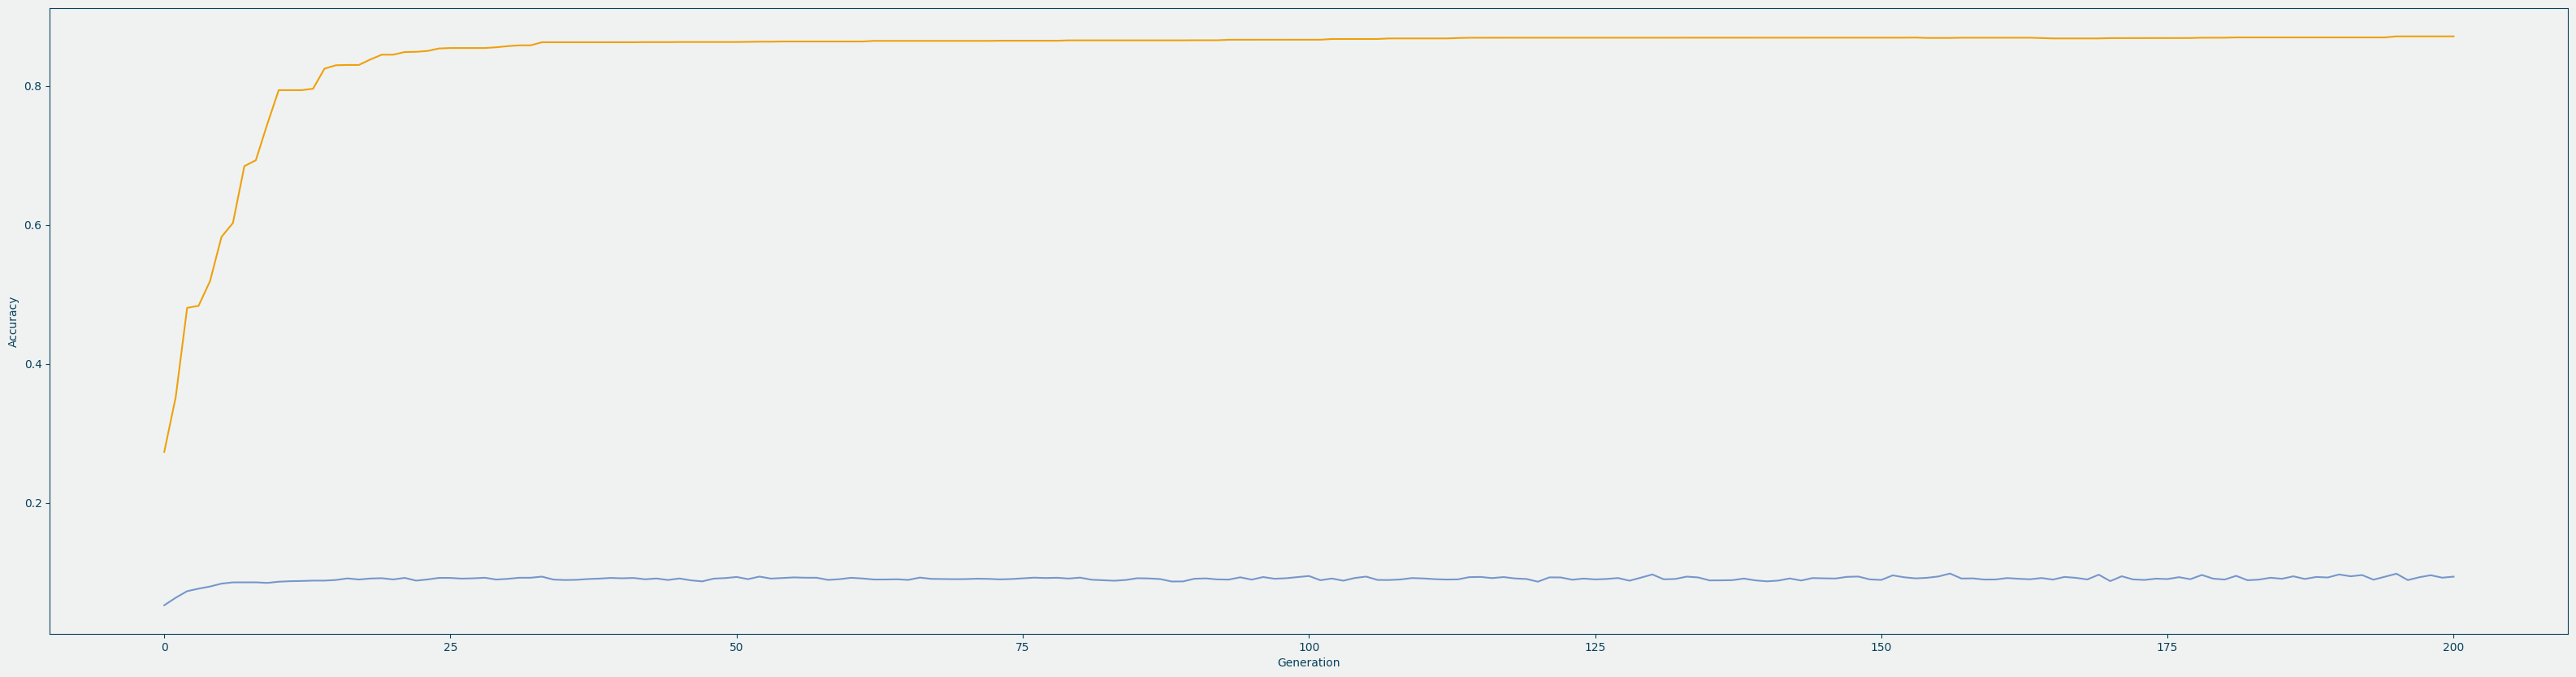

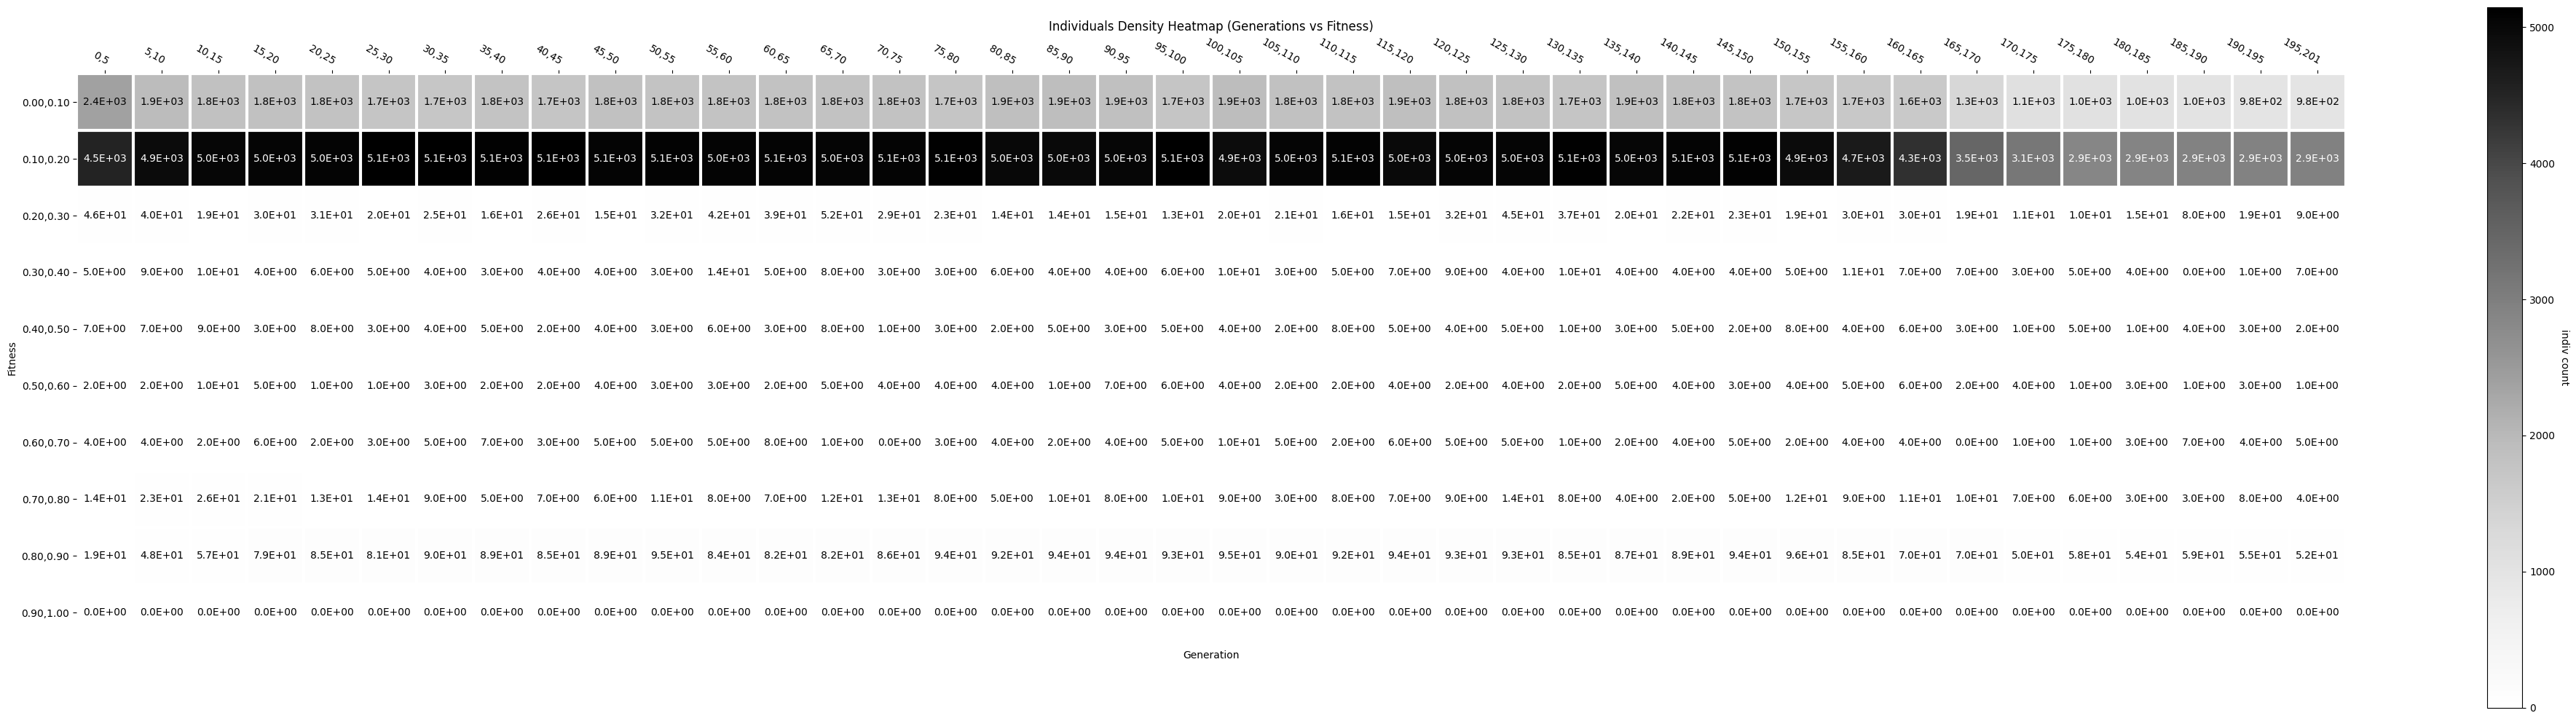

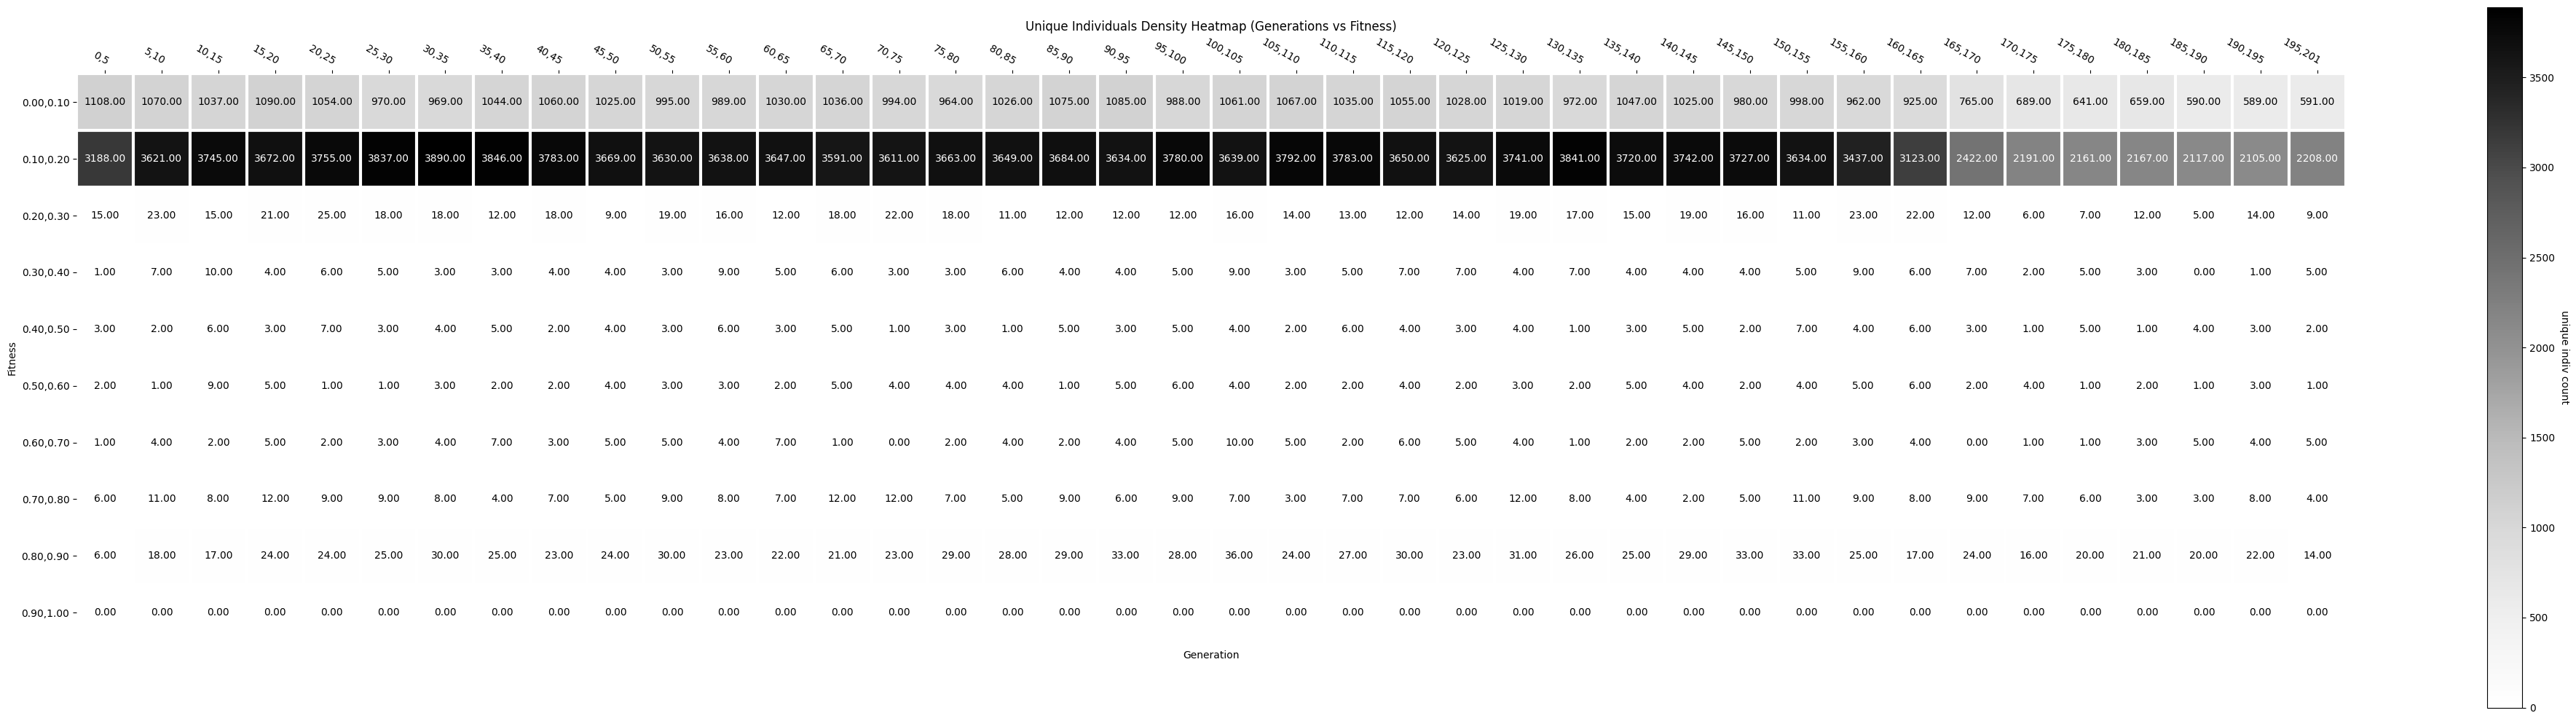

c:\Users\p288427\Github\autolr\many_results\many_runs_old_mut\cif
iteration_0.json
iteration_1.json
iteration_2.json
iteration_3.json
iteration_4.json
iteration_5.json
iteration_6.json
iteration_7.json
iteration_8.json
iteration_9.json
iteration_10.json
iteration_11.json
iteration_12.json
iteration_13.json
iteration_14.json
iteration_15.json
iteration_16.json
iteration_17.json
iteration_18.json
iteration_19.json
iteration_20.json
iteration_21.json
iteration_22.json
iteration_23.json
iteration_24.json
iteration_25.json
iteration_26.json
iteration_27.json
iteration_28.json
iteration_29.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iteratio

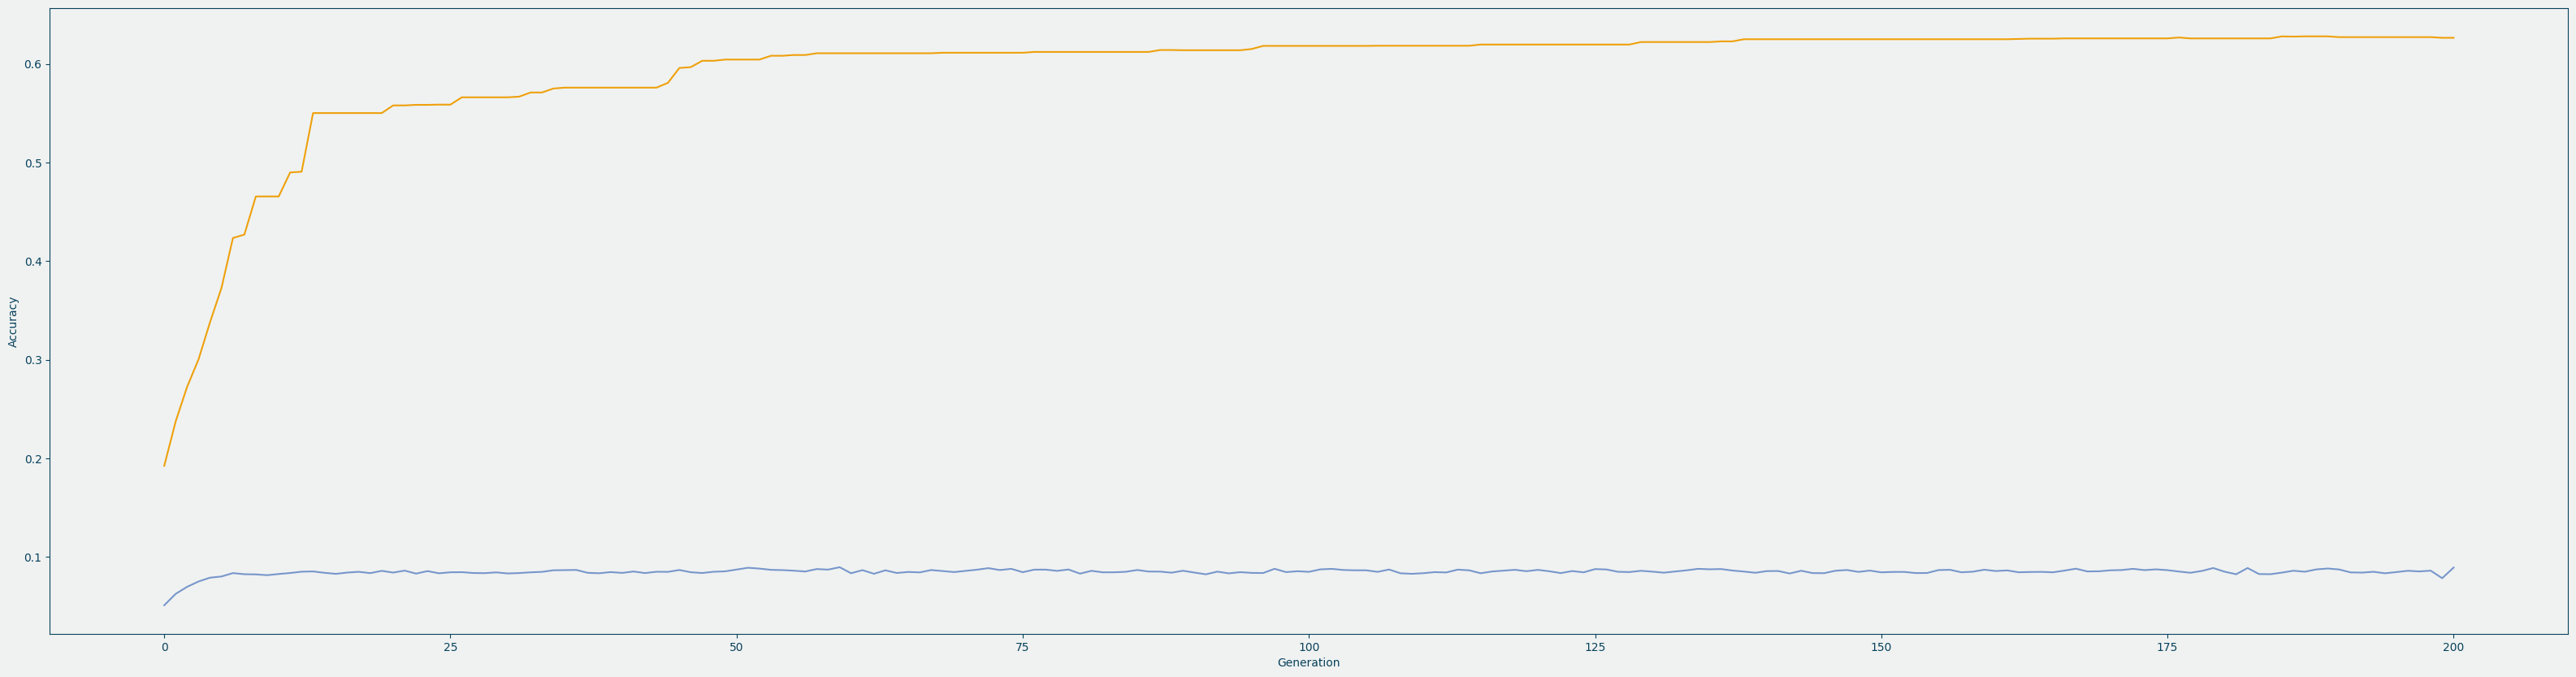

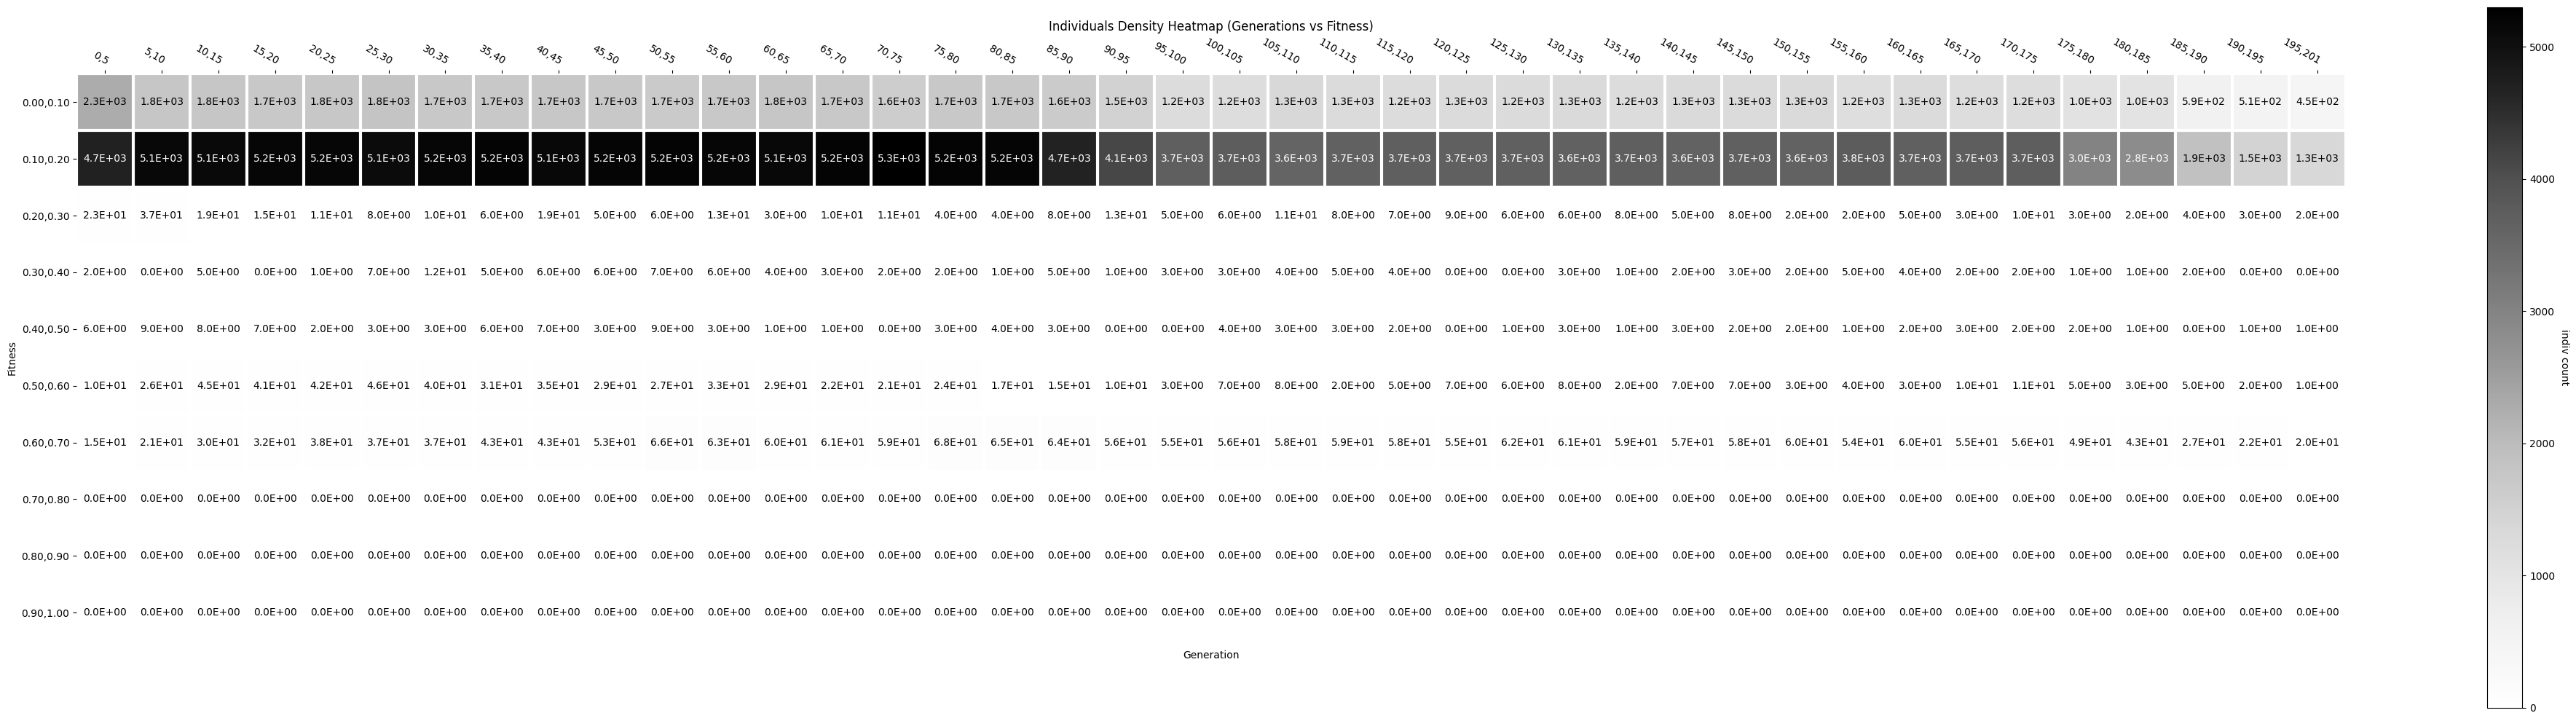

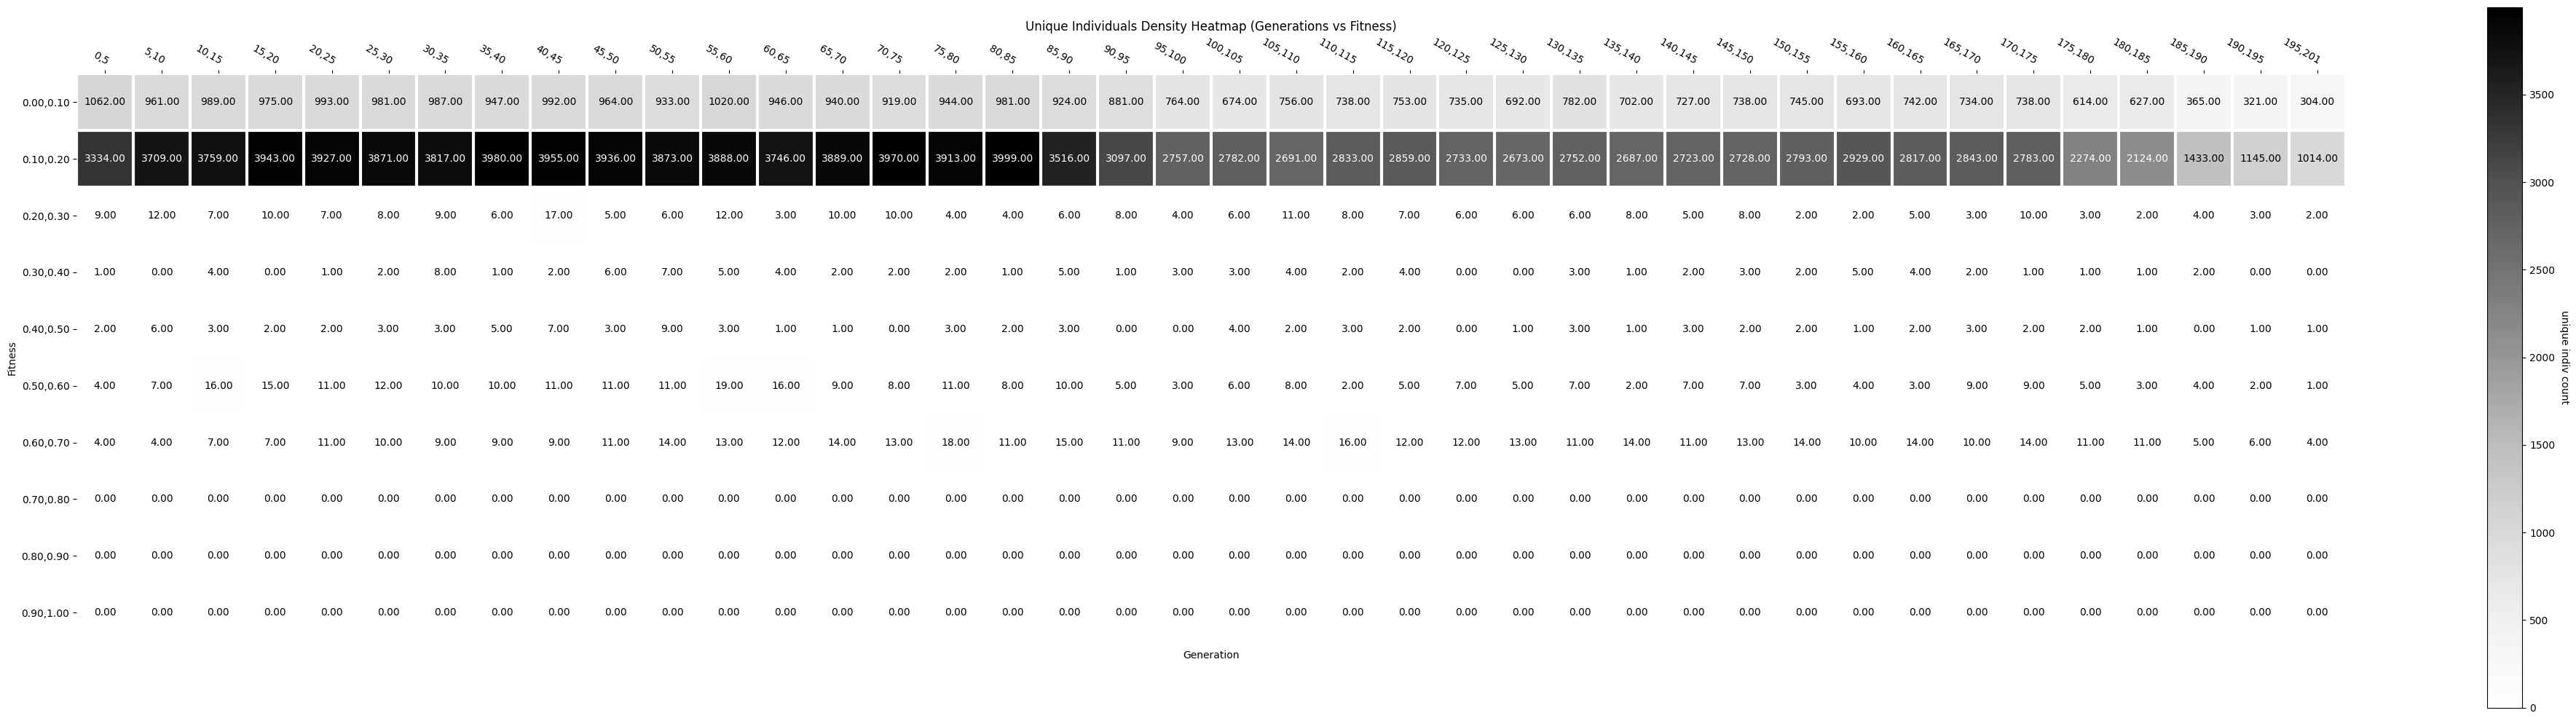

c:\Users\p288427\Github\autolr\many_results\many_runs_old_mut\cif_from_fmni_rapid_transfer
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iteration_52.json
iteration_53.json
iteration_54.json
iteration_55.json
iteration_56.json
iteration_57.json
iteration_58.json
iteration_59.json
iteration_60.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration

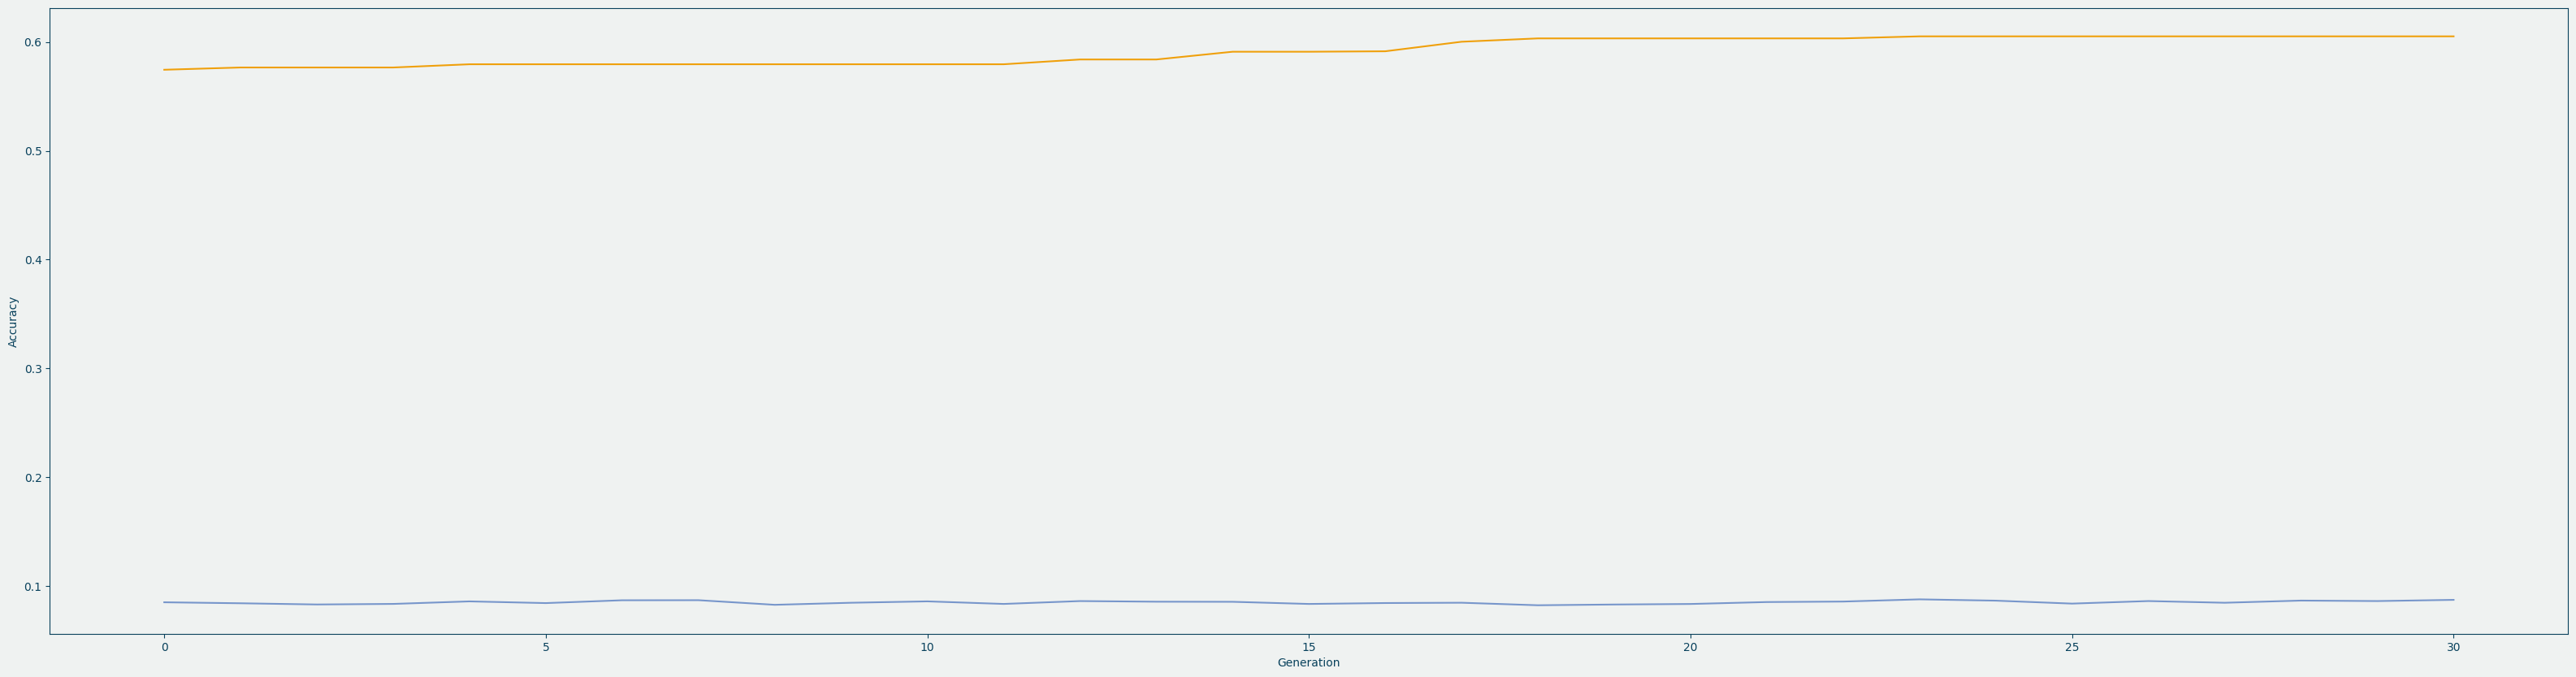

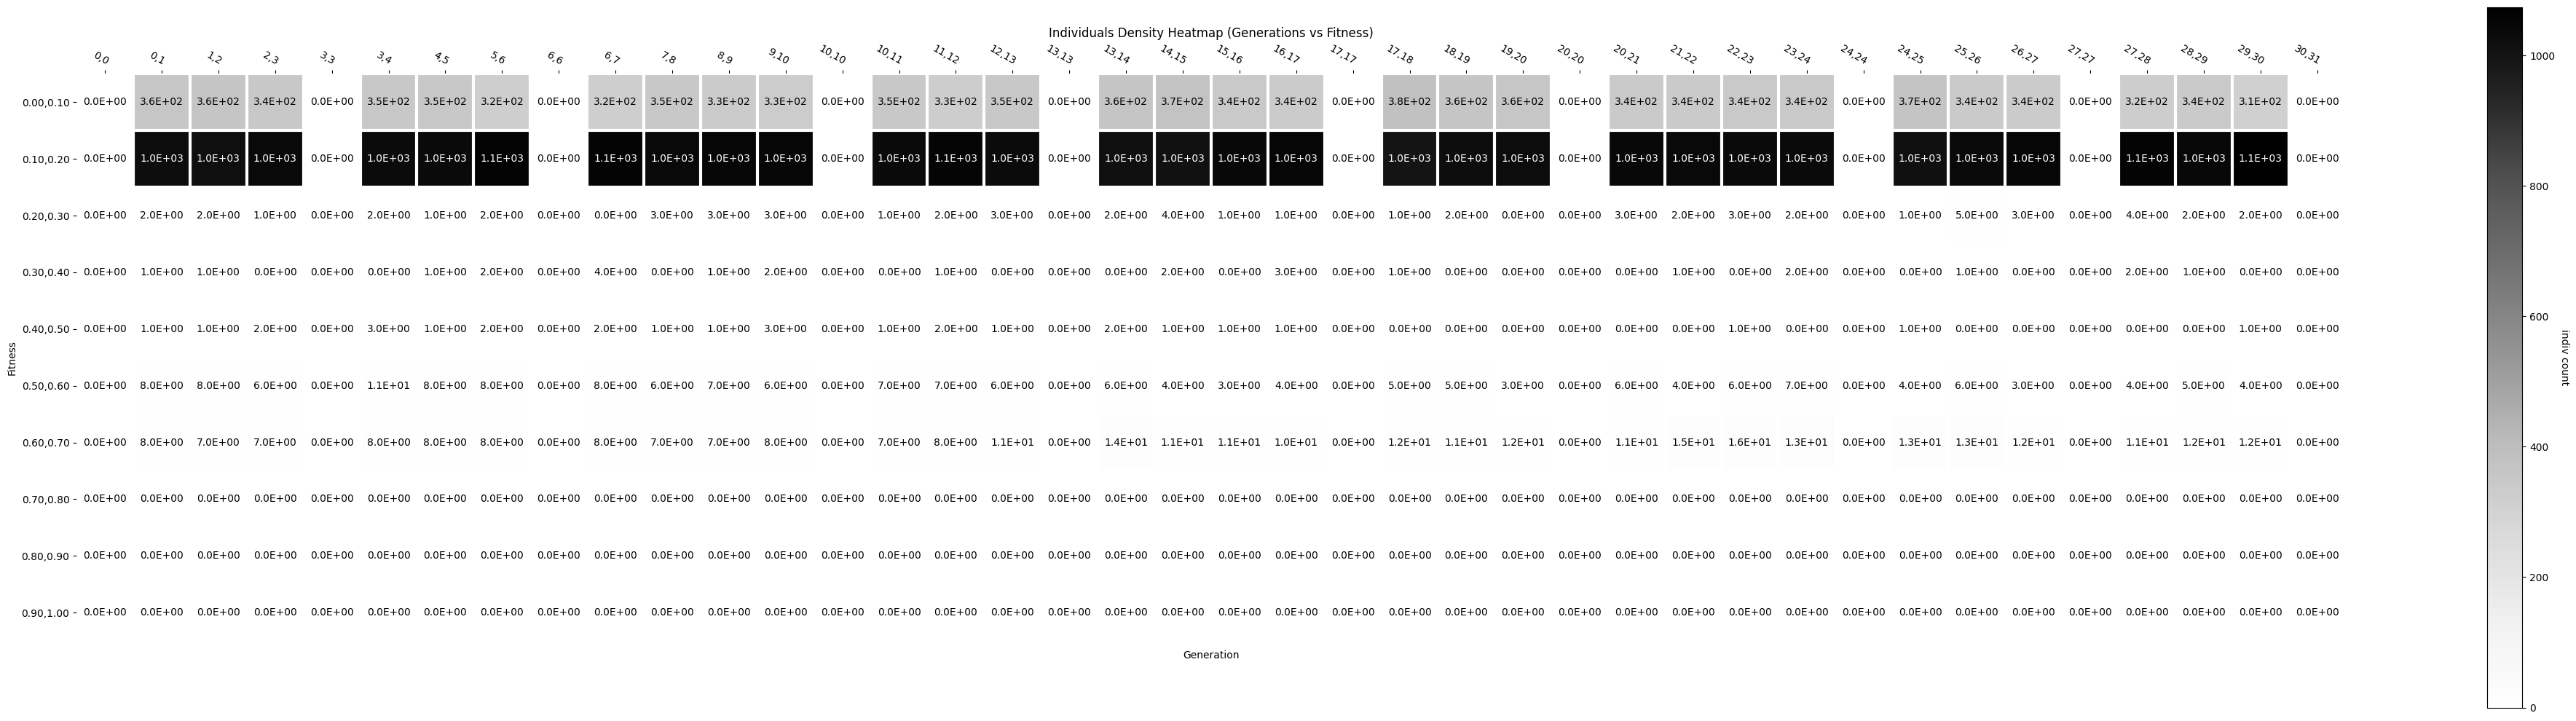

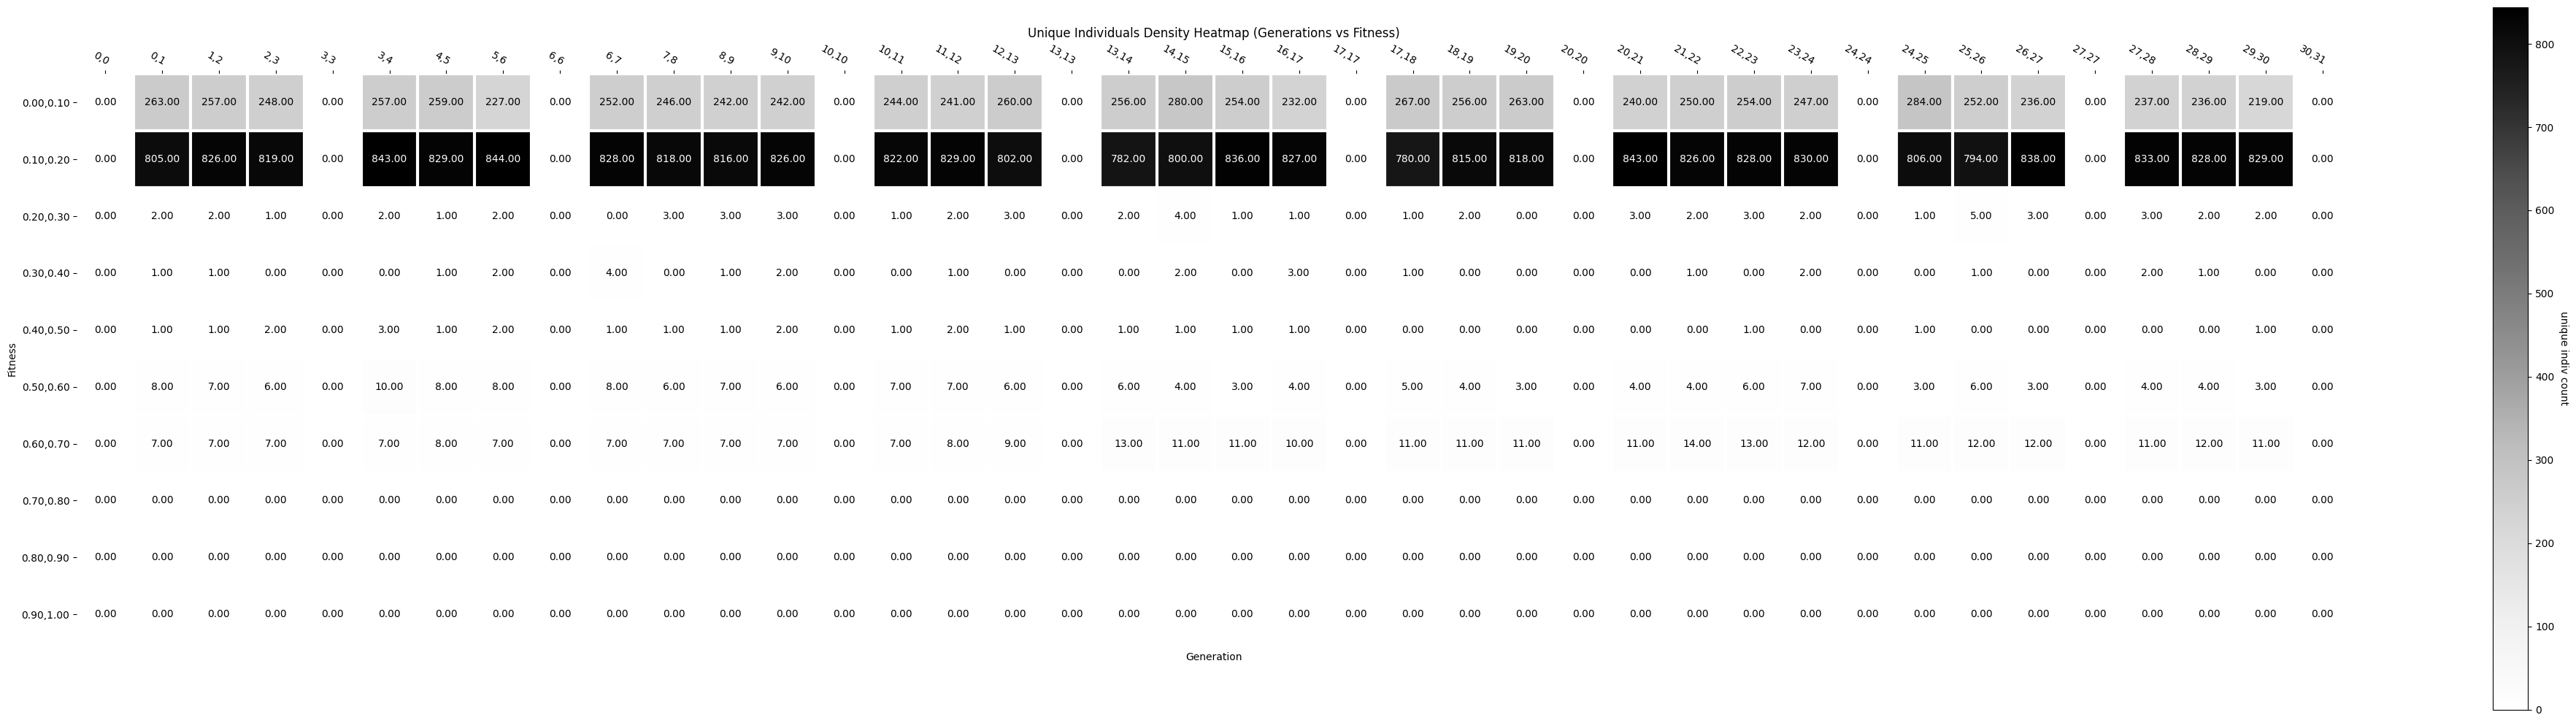

c:\Users\p288427\Github\autolr\many_results\many_runs\fmni
iteration_0.json
iteration_1.json
iteration_2.json
iteration_3.json
iteration_4.json
iteration_5.json
iteration_6.json
iteration_7.json
iteration_8.json
iteration_9.json
iteration_10.json
iteration_11.json
iteration_12.json
iteration_13.json
iteration_14.json
iteration_15.json
iteration_16.json
iteration_17.json
iteration_18.json
iteration_19.json
iteration_20.json
iteration_21.json
iteration_22.json
iteration_23.json
iteration_24.json
iteration_25.json
iteration_26.json
iteration_27.json
iteration_28.json
iteration_29.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iteration_52.js

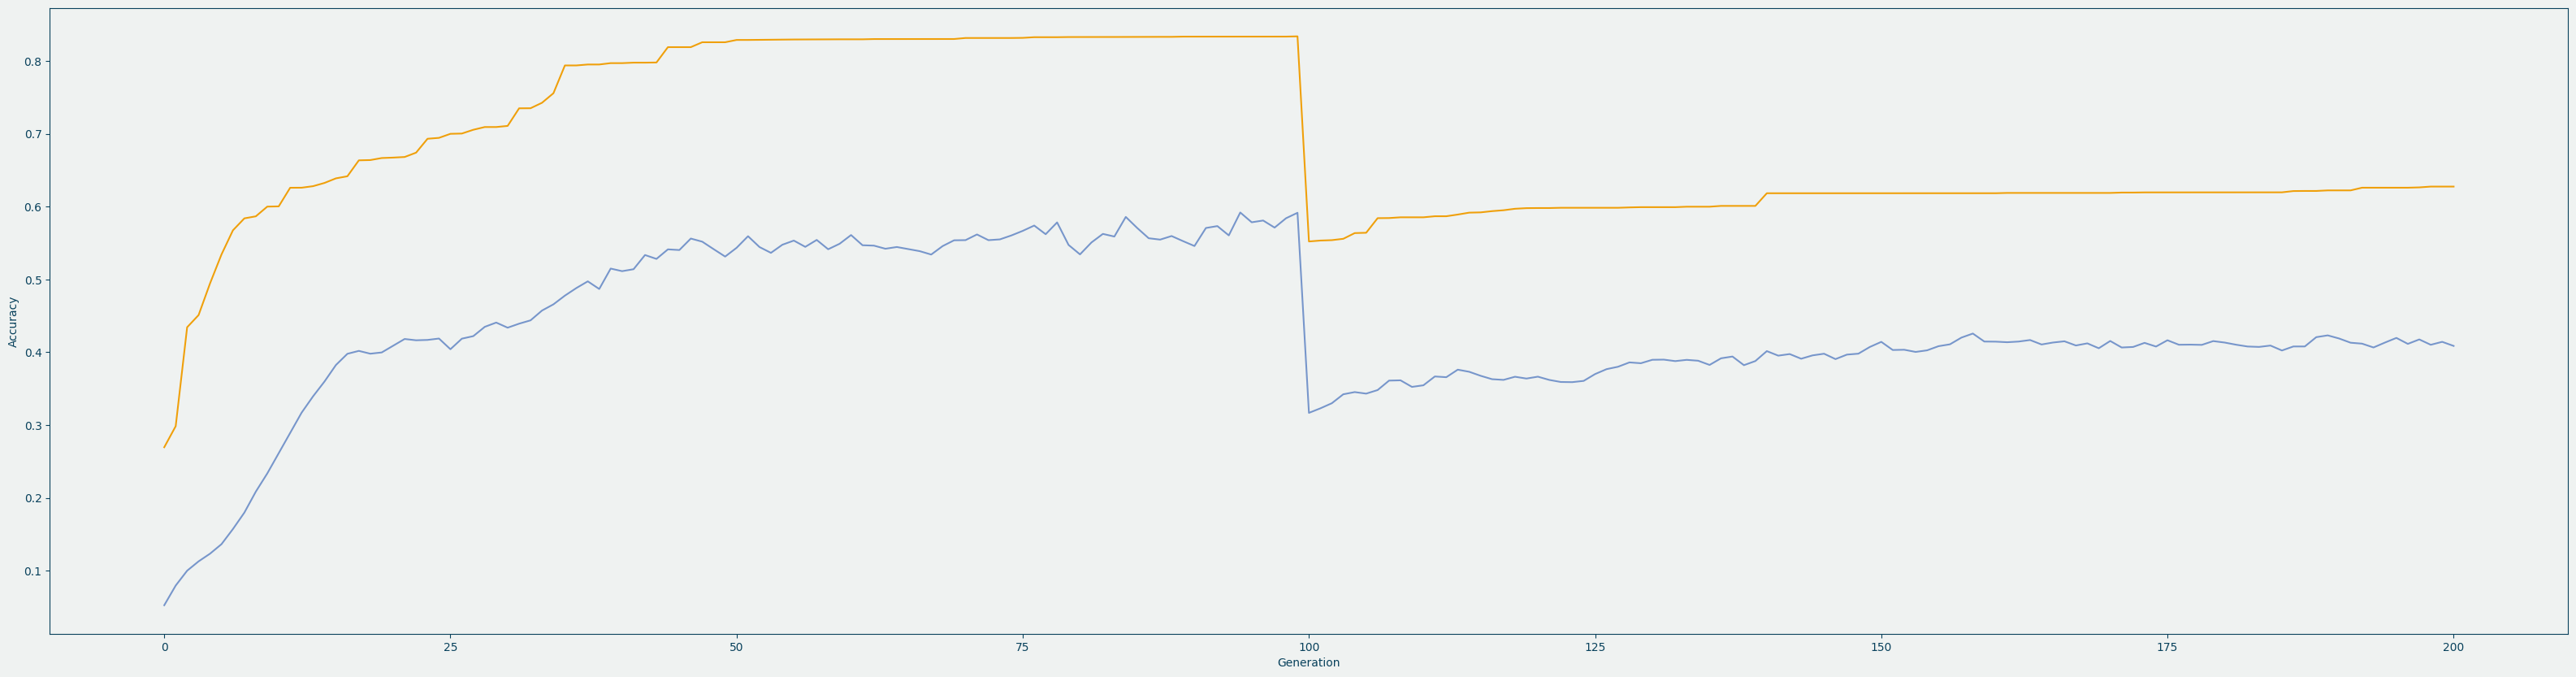

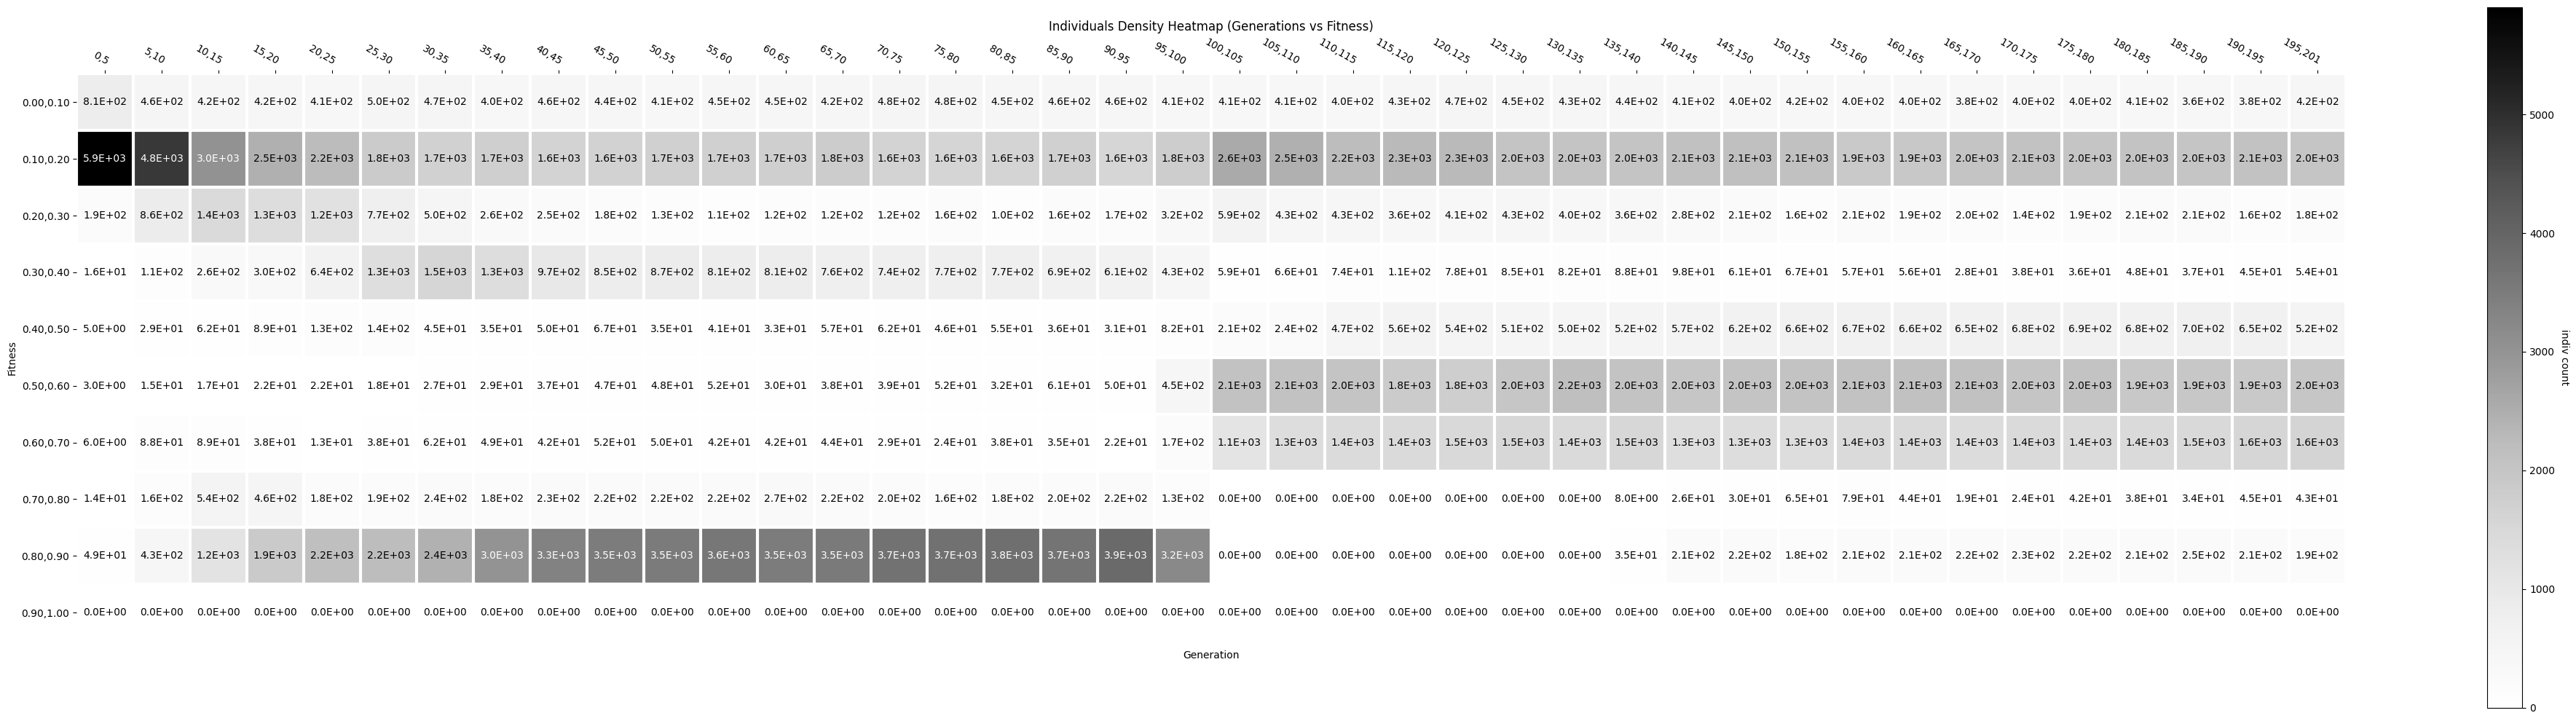

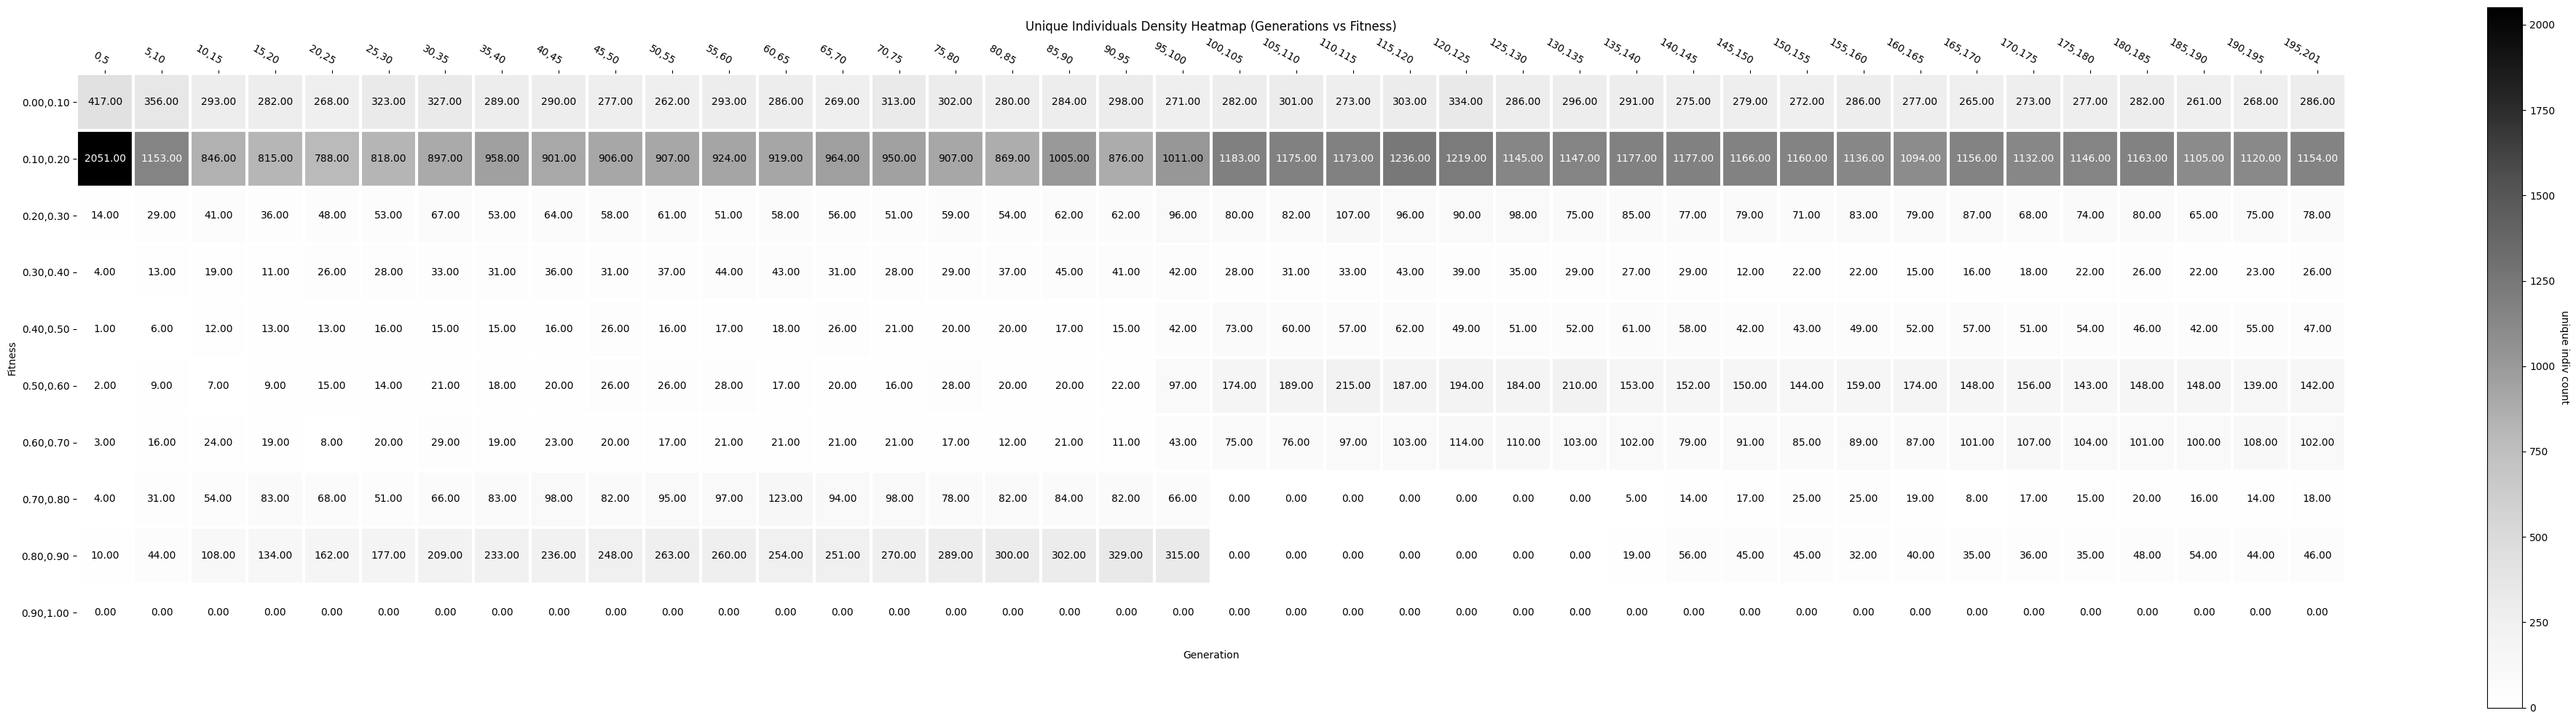

c:\Users\p288427\Github\autolr\many_results\many_runs\cif
iteration_0.json
iteration_1.json
iteration_2.json
iteration_3.json
iteration_4.json
iteration_5.json
iteration_6.json
iteration_7.json
iteration_8.json
iteration_9.json
iteration_10.json
iteration_11.json
iteration_12.json
iteration_13.json
iteration_14.json
iteration_15.json
iteration_16.json
iteration_17.json
iteration_18.json
iteration_19.json
iteration_20.json
iteration_21.json
iteration_22.json
iteration_23.json
iteration_24.json
iteration_25.json
iteration_26.json
iteration_27.json
iteration_28.json
iteration_29.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iteration_52.jso

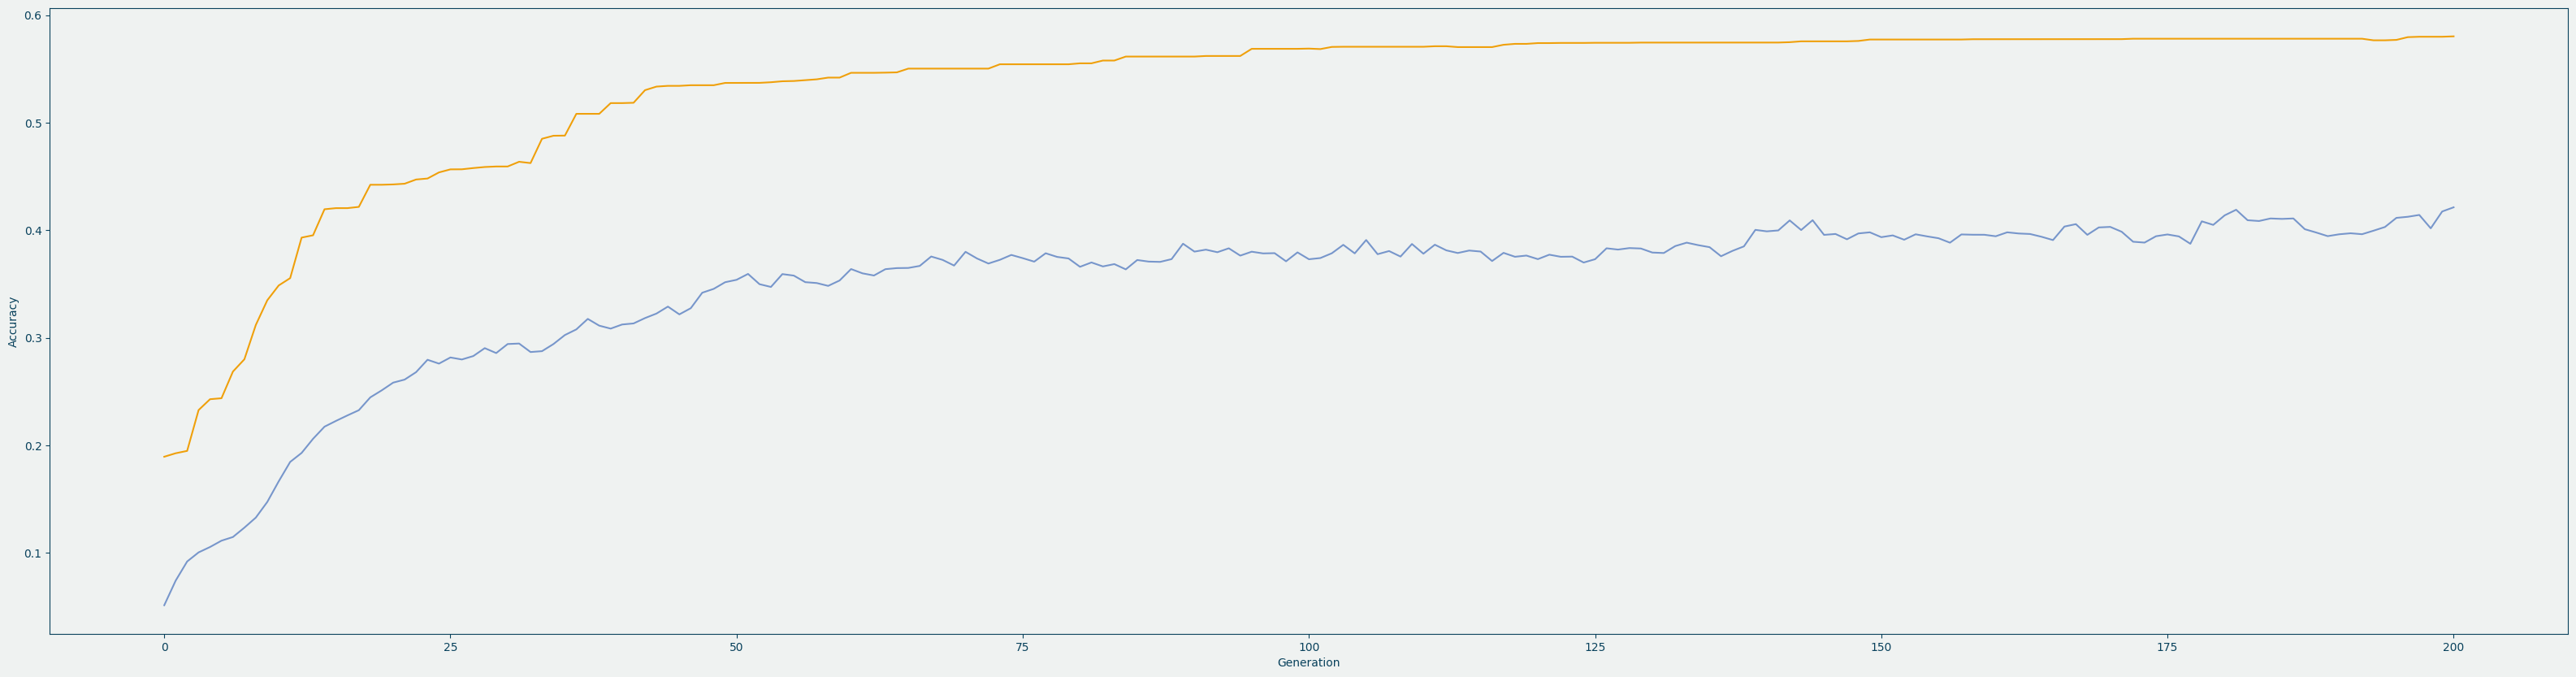

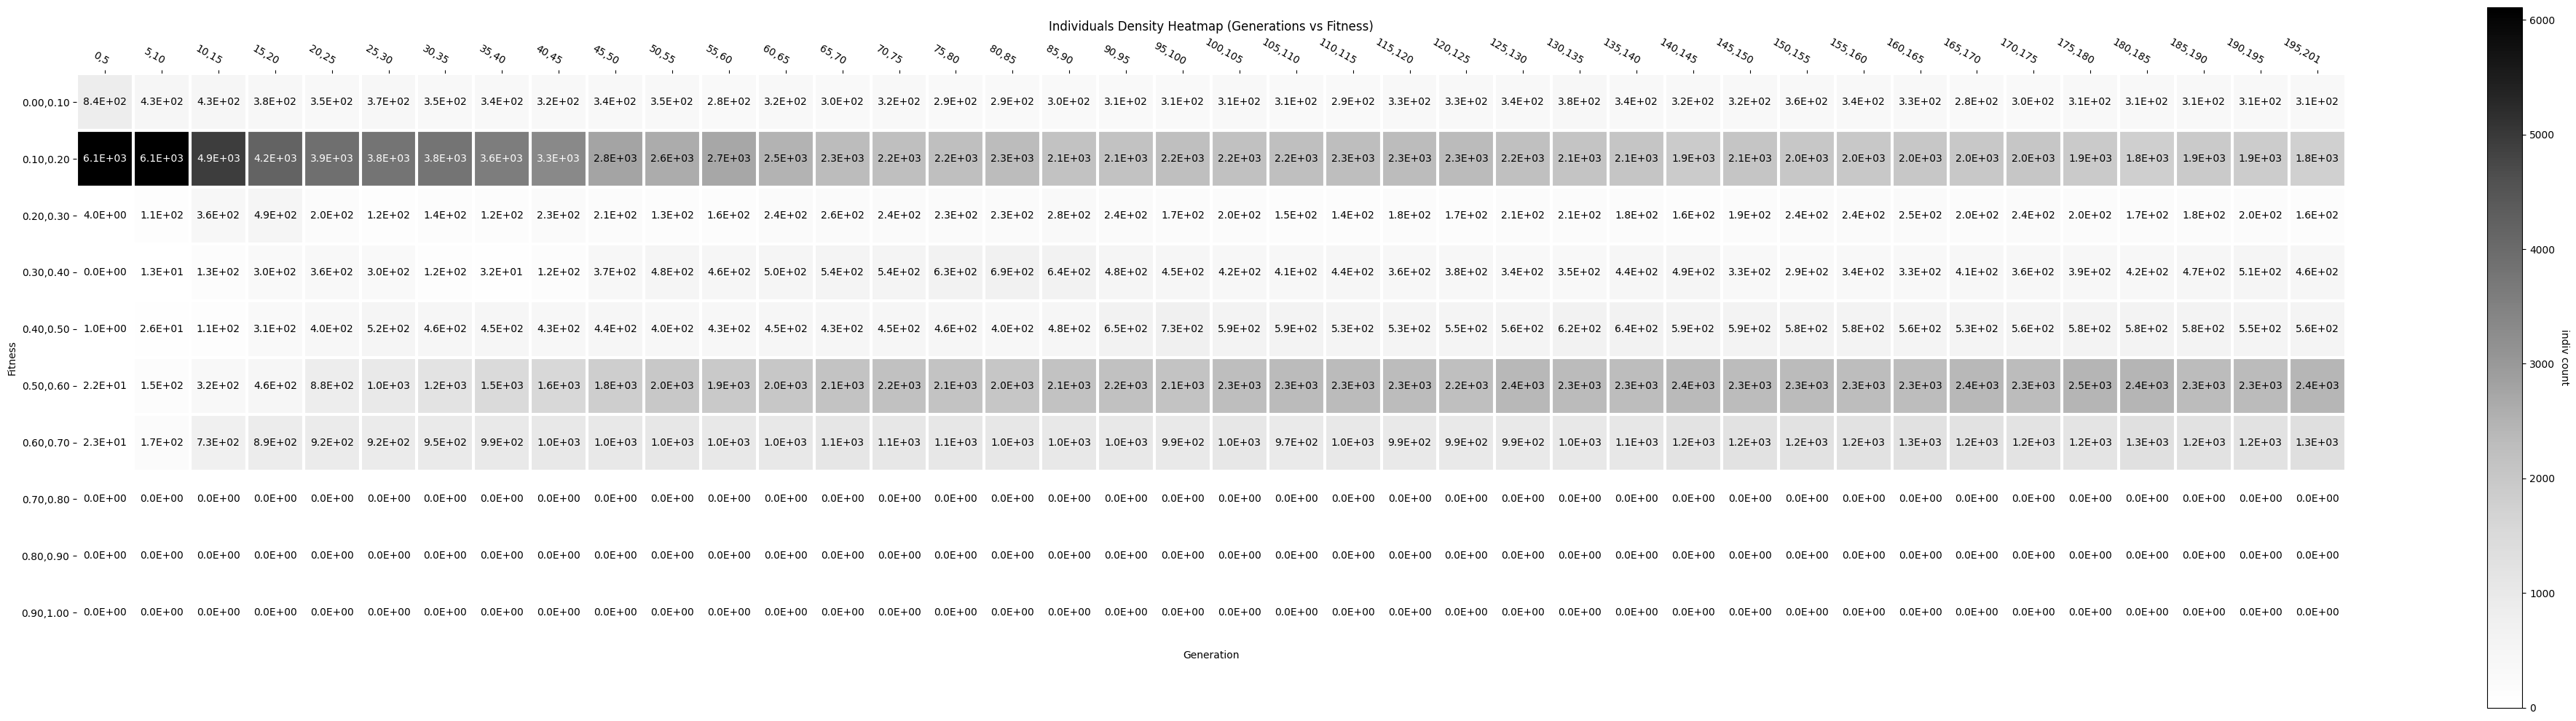

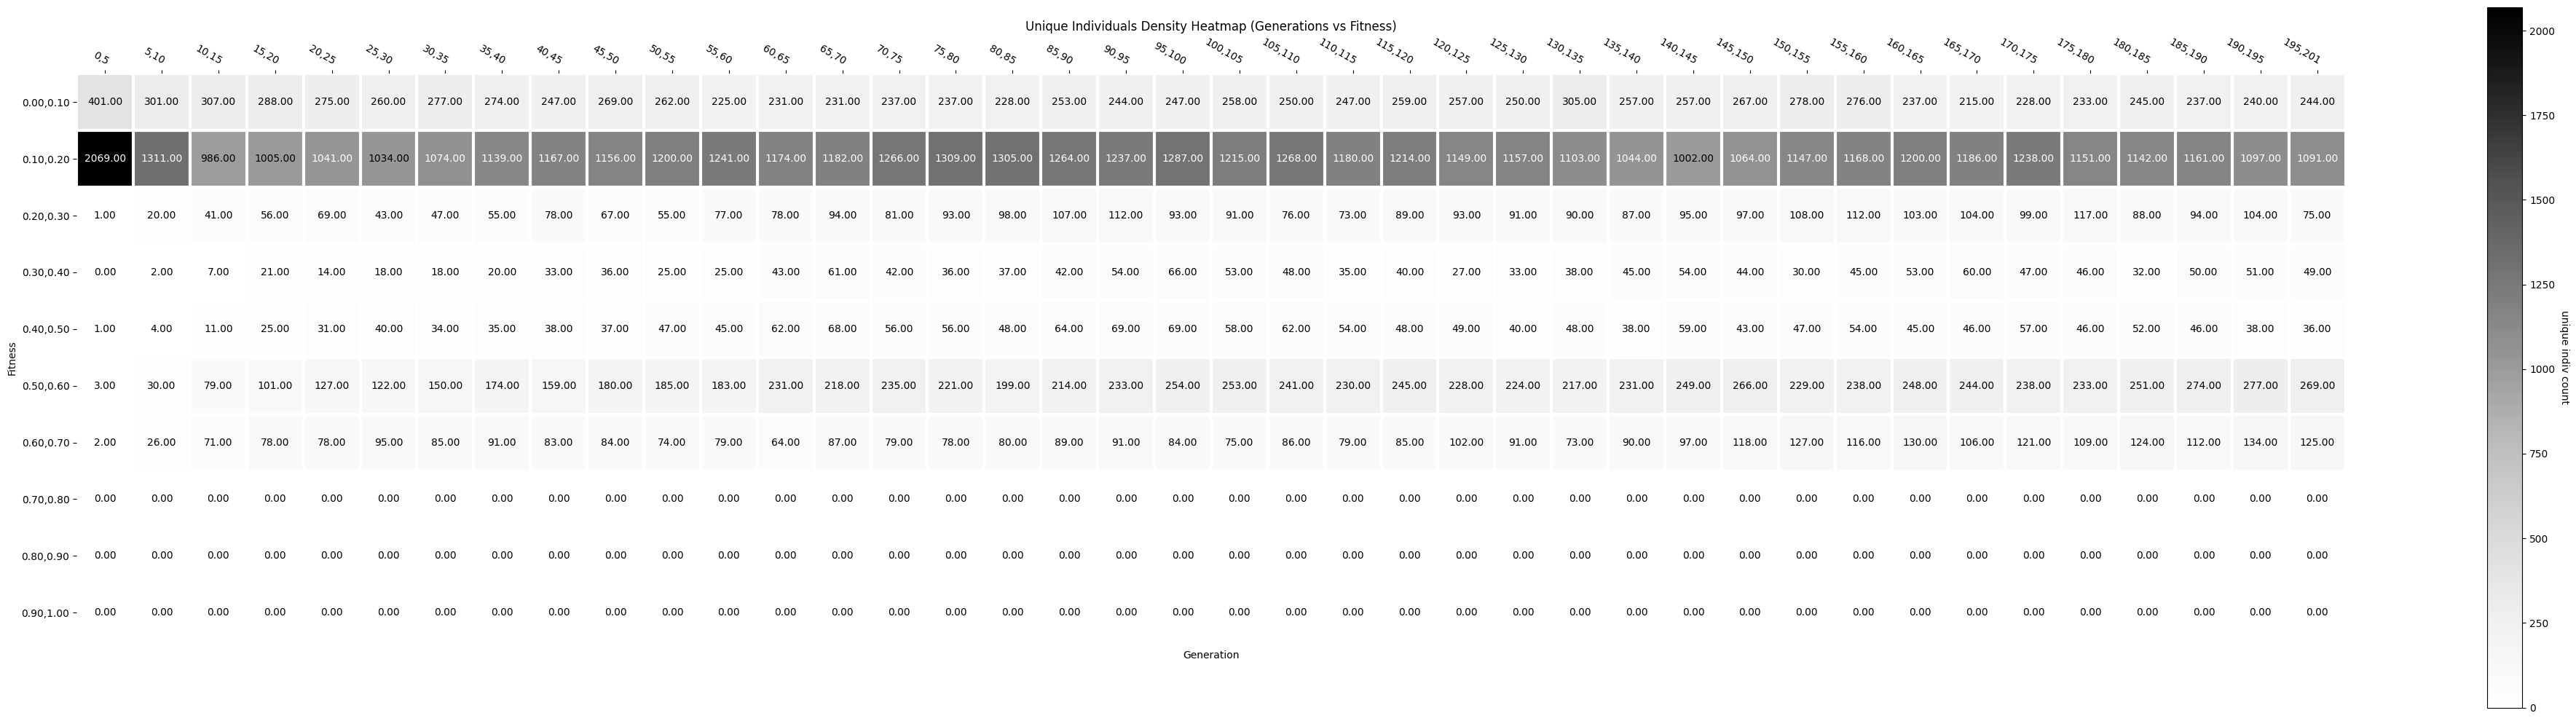

c:\Users\p288427\Github\autolr\many_results\many_runs\cif_from_fmni_rapid_transfer
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json
iteration_50.json
iteration_51.json
iteration_52.json
iteration_53.json
iteration_54.json
iteration_55.json
iteration_56.json
iteration_57.json
iteration_58.json
iteration_59.json
iteration_60.json
iteration_30.json
iteration_31.json
iteration_32.json
iteration_33.json
iteration_34.json
iteration_35.json
iteration_36.json
iteration_37.json
iteration_38.json
iteration_39.json
iteration_40.json
iteration_41.json
iteration_42.json
iteration_43.json
iteration_44.json
iteration_45.json
iteration_46.json
iteration_47.json
iteration_48.json
iteration_49.json

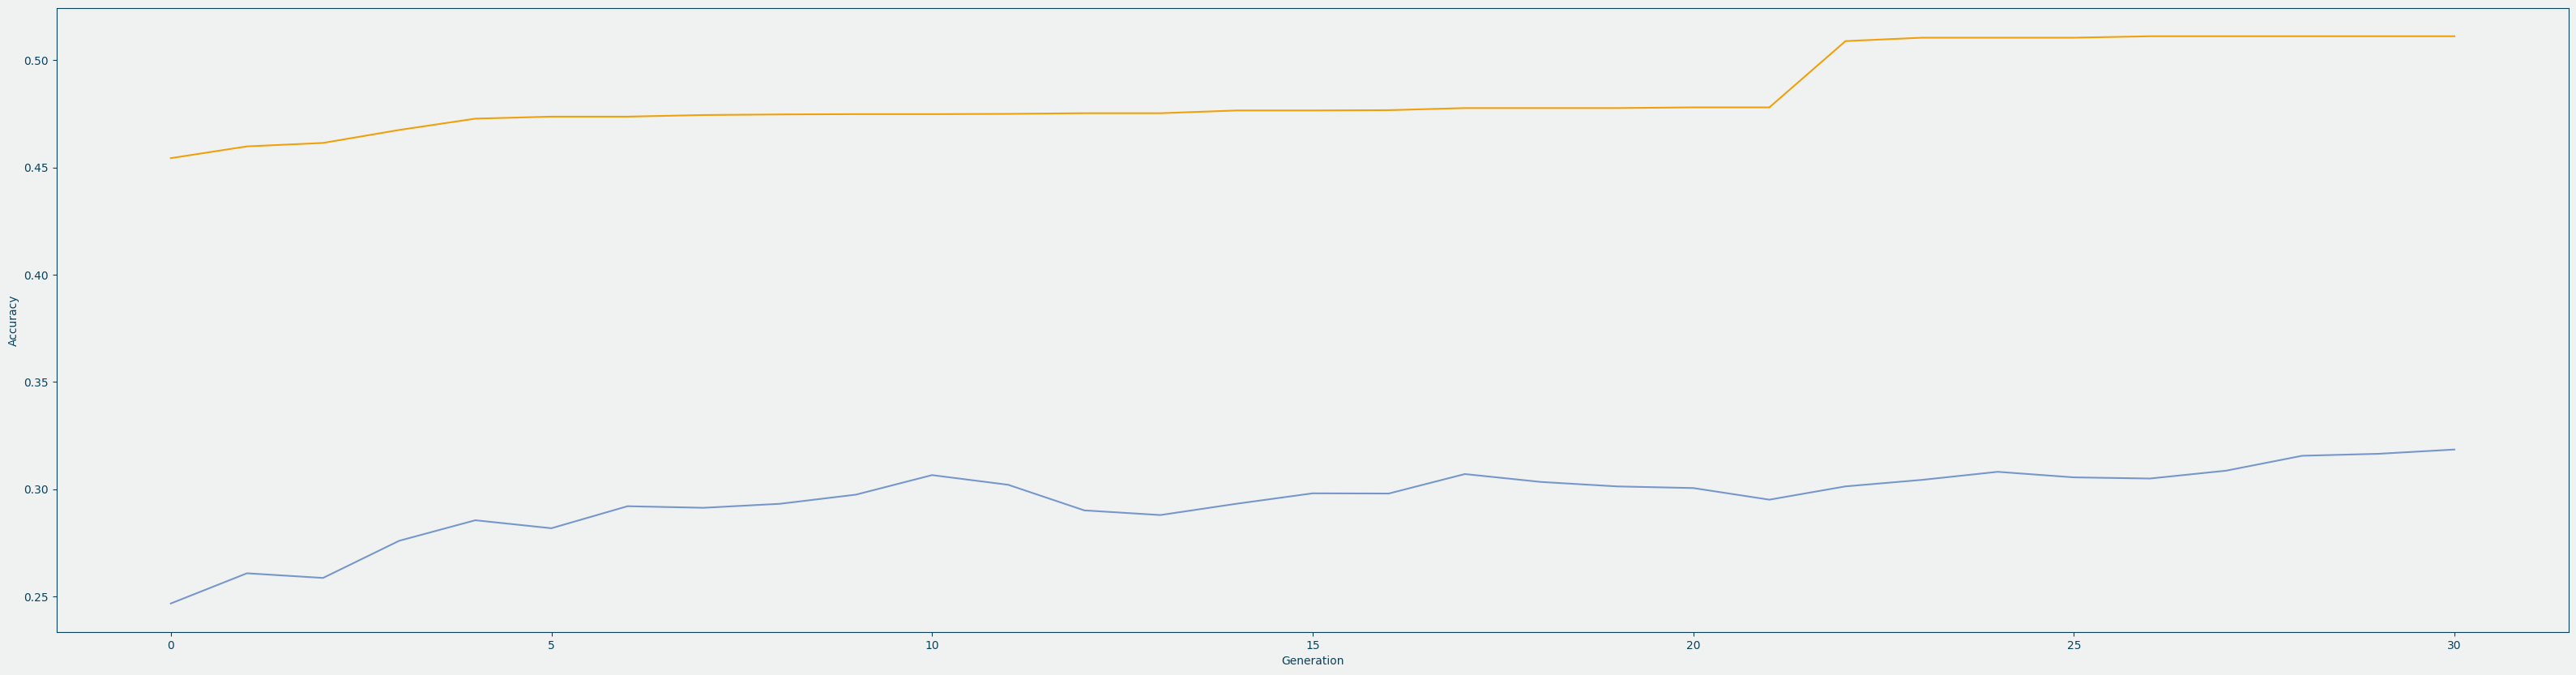

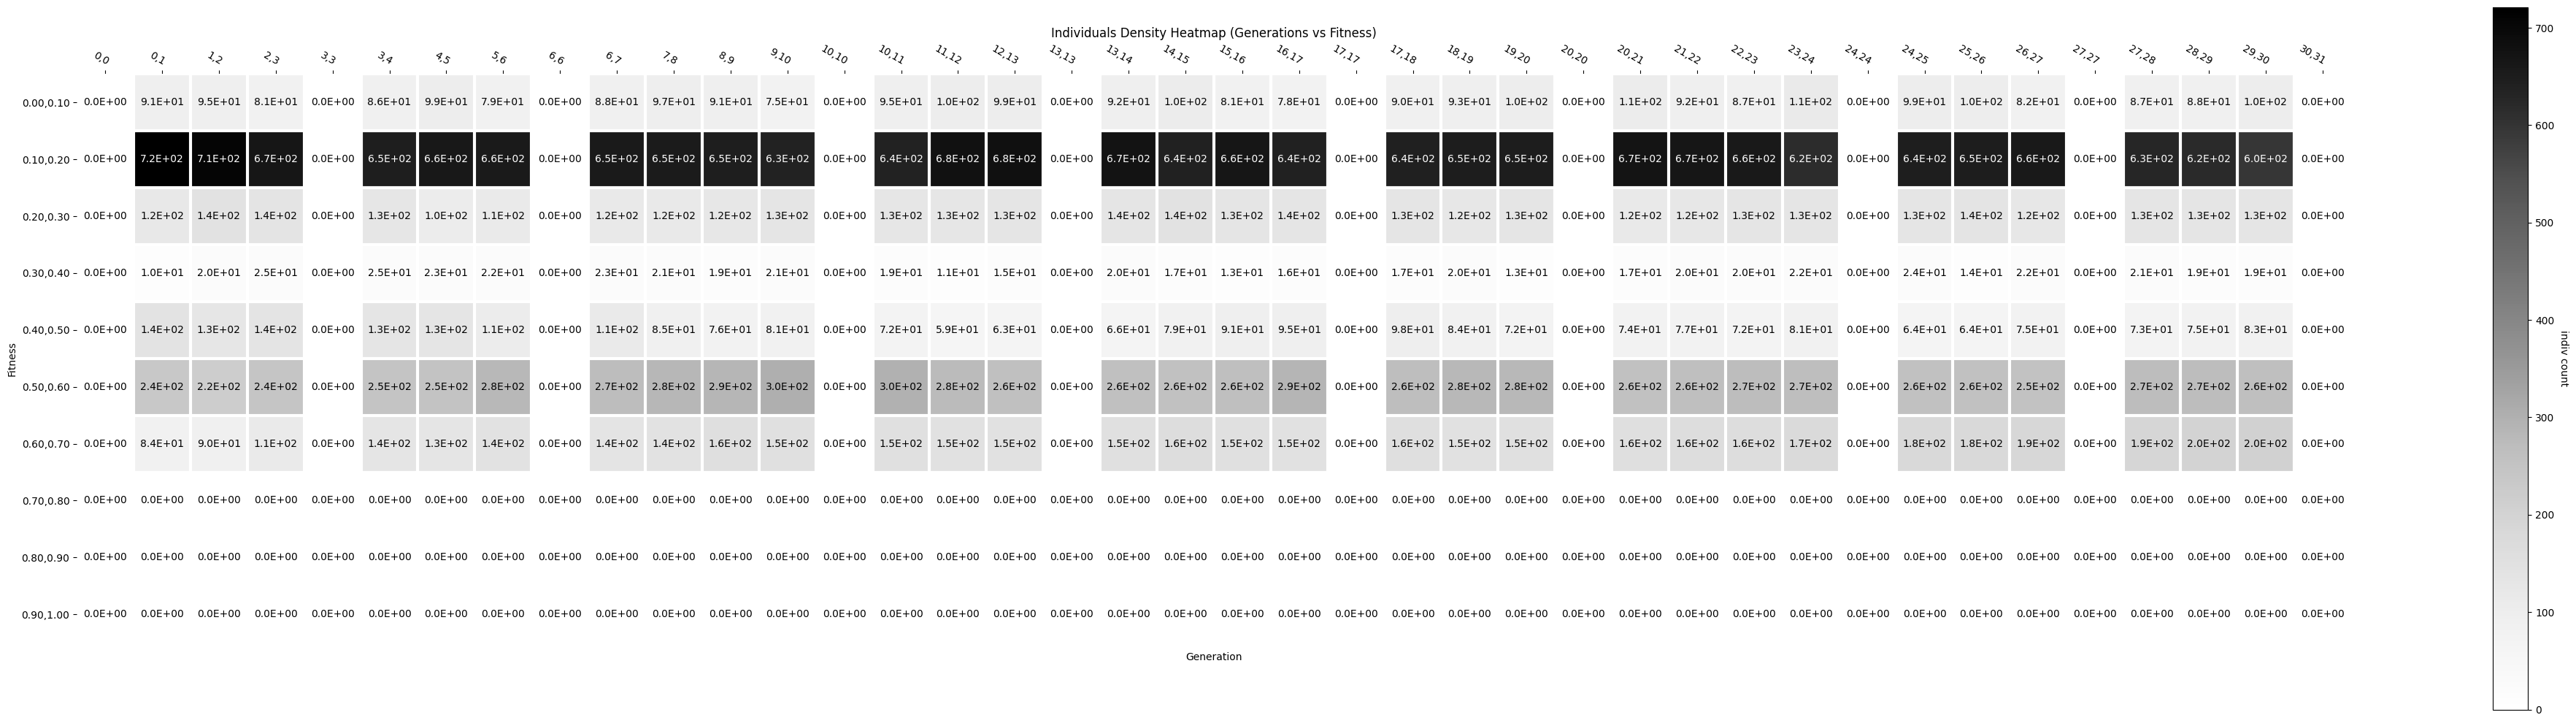

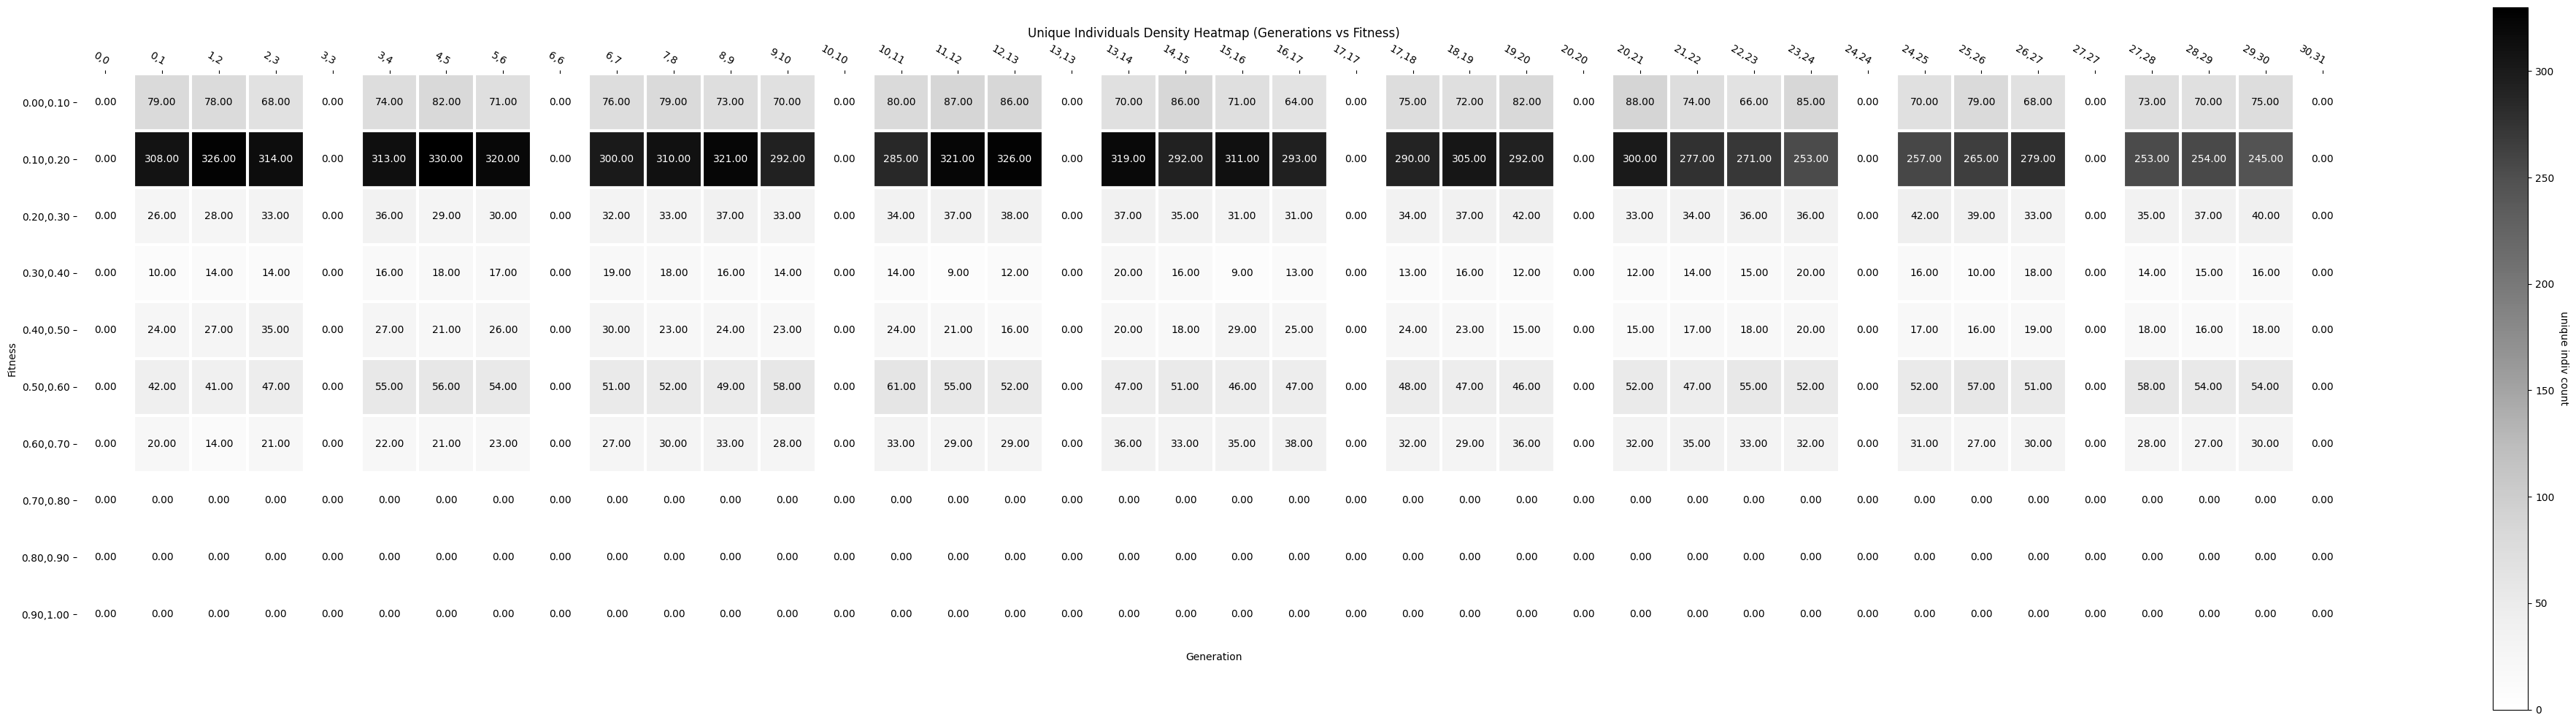

In [37]:
run_number = range(1,15)
tasks = ["fmni", "cif", "cif_from_fmni_rapid_transfer"]
folders = ["many_runs_old_mut", "many_runs"]
over_folder="many_results\\"

for folder in folders:
  for task in tasks:
    results = load_results(folder=f'{over_folder}{folder}', task=task, run_number=run_number)
    data = process_results(results= results, run_number=run_number)

    columns, rows = (40, 10)
    plt.rcParams['figure.figsize'] = [columns, rows]

    fit_floor = 0.0
    fit_ceil = 1.0
    gen_floor = 0.0
    gen_ceil = float(len(data['epochs']))

    plot_fit(data["epochs"], data['averages_all'], data['bests_all'], data['task'], folder = folder)
    pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data['task'], folder = folder)
    unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data['task'], folder = folder)
    #unique_indivs_curve(data["indivs_epochs"], data["indivs"], fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil, task = data['task'], folder = folder)

# Beyond this point is code for archive analysis, this is not refined. Do not use unless necessary

In [ ]:
archive_list = []
for i in run_number: 
    it = 1 
    try:
        while True:
            archive = load_archive(path, i, it)
            it += 1
    except:
        pass
    try:
        print(f"loading archive {it - 1} for run {i}")
        archive = load_archive(path, i, it - 1)
        for x in archive:
            if 'fitness' in archive[x]:
                archive_list.append([x, archive[x], archive[x]['fitness'], i])
    except:
        print(f"Run {i} has no archive")
archive_list.sort(key=lambda x : x[2])



In [ ]:
archive_list
with open('data.json', 'w') as f:
    json.dump(archive_list, f)

In [ ]:
it = 0
while it < 10:
    print(archive_list[it])
    it+=1

In [ ]:
def turn_to_expr(phenotype, tree):
    if phenotype == "":
        return tree
    
    if phenotype[0:9] == "multiply(":
        #print("multiply")
        phenotype = phenotype[9:]
        node = Node("*", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:14] == "divide_no_nan(":
        phenotype = phenotype[14:]
        node = Node("/", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "add(":
        phenotype = phenotype[4:]
        node = Node("+", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "pow(":
        phenotype = phenotype[4:]
        node = Node("^", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "subtract(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "grad":
        phenotype = phenotype[4:]
        node = Node("grad", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "beta":
        phenotype = phenotype[4:]
        node = Node("beta", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "alpha":
        phenotype = phenotype[5:]
        node = Node("alpha", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sigma":
        phenotype = phenotype[5:]
        node = Node("sigma", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "negative(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sqrt(":
        phenotype = phenotype[5:]
        node = Node("sqrt", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:7] == "square(":
        phenotype = phenotype[7:]
        node = Node("square", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:2] == ", ":
        phenotype = phenotype[2:]
        return turn_to_expr(phenotype, tree)     
    elif phenotype[0] == ")":
        phenotype = phenotype[1:]
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "constant(":
        if phenotype[9:12] == "0.0" or phenotype[9:13] == "1.0)" or phenotype[9:13] == "1.0,":
            node = Node(phenotype[9:12], tree, 0)
            phenotype = phenotype[12:]
            tree.insert(node)
            tree = tree.get_next()           
        else:
            node = Node(phenotype[9:9+14], tree, 0)
            phenotype = phenotype[9+14:]
            tree.insert(node)
            tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    else:
        raise Exception(phenotype)
        
def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    for x in [alpha_func_string, beta_func_string, sigma_func_string, grad_func_string]:
        print(x)    
        turn_to_expr(x, Node("", None, 1)).to_string()

    return grad_func_string

for indiv in data['indivs']:
    math_phenotype(indiv['phenotype'])

In [ ]:
a = "multiply("
print(a[0:9])
print(a[9:])

In [ ]:
from copy import deepcopy
import csv
from pickle import NONE
from utils.data_functions import load_fashion_mnist_training, load_cifar10_training, load_mnist_training, select_fashion_mnist_training
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import load_model
from tensorflow import keras
from keras import backend as K
from optimizers.custom_optimizer import CustomOptimizer
import datetime
experiment_time = datetime.datetime.now()

cached_dataset = None
cached_model = None

def train_model_tensorflow_cifar10(phen_params):
    phen, params = phen_params
    validation_size = params['VALIDATION_SIZE']
    fitness_size =params['FITNESS_SIZE'] 
    batch_size = params['BATCH_SIZE']
    epochs = params['EPOCHS']
    patience = params['PATIENCE']

    # Note that globals are borderline -- consider an object or a closure 
    # deliberately using globals() to make it ugly...
    if globals()['cached_dataset'] == None:
        globals()['cached_dataset'] = load_cifar10_training(validation_size=validation_size, test_size=fitness_size)
    
    if globals()['cached_model'] == None:
        globals()['cached_model'] = load_model(params['MODEL'], compile=False)
        
    # we assume validation and test sets are deterministic
    dataset = globals()['cached_dataset'] 
    model = tf.keras.models.clone_model(globals()['cached_model'])

    weights = model.get_weights()
    model.set_weights(weights)  

    # optimizer is constant aslong as phen doesn't changed?
    # -> opportunity to cache opt and compiled model
    opt = CustomOptimizer(phen=phen, model=model)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True)

    score = model.fit(dataset['x_train'], dataset['y_train'],
        batch_size=batch_size,
        epochs=epochs,
        verbose=2,
        validation_data=(dataset['x_val'], dataset['y_val']),
        validation_steps= validation_size // batch_size,
        callbacks=[
            early_stop
        ])

    K.clear_session()
    results = {}
    for metric in score.history:
        results[metric] = []
        for n in score.history[metric]:
            results[metric].append(n)
    test_score = model.evaluate(x=dataset['x_test'],y=dataset["y_test"], verbose=0, callbacks=[keras.callbacks.History()])
    return test_score[-1], results
